# Feature selection and classification of women with PCOS 

20BCE1871 - S Gopi

20BCE1212 - ANKANA CHATTERJEE

20BCE1470 - KOVI YASASWINI

In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

In [2]:
# Importing the required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold,cross_val_predict
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA

In [3]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold 
from sklearn.feature_selection import SelectKBest

In [4]:
# Turned off warnings

import warnings
warnings.filterwarnings('ignore')

In [5]:
# To compute execution time of each cell
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2023-04-09 23:53:09 +05:30)


## Loading data

In [6]:
# Loading the data
df = pd.read_excel("PCOS_data_without_infertility.xlsx", sheet_name="Full_new")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

In [7]:
df.head()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN


time: 16 ms (started: 2023-04-09 23:53:10 +05:30)


In [8]:
target_counts=df['PCOS (Y/N)'].value_counts()
target_counts

0    364
1    177
Name: PCOS (Y/N), dtype: int64

time: 0 ns (started: 2023-04-09 23:53:10 +05:30)


About the data:

This dataset contains all physical and clinical parameters to determine PCOS and infertility related issues. There are a total of 44 parameters.

This data is collected from 10 different hospitals across Kerala, India.

The unit used is feet to cm

Blood pressure entered as systolic and diastolic separately

RBS means Random glucose test

Beta-HCG cases are mentioned as Case I and II

Blood Group indications: A+ = 11, A- = 12, B+ = 13, B- = 14, O+ =15, O- = 16, AB+ =17, AB- = 18

## Data pre-processing


Let us remove blankspaces in the column names

In [9]:
colnames = list(df.columns)
for i in range(len(colnames)):
  colnames[i] = colnames[i].strip()
df.columns = colnames

time: 0 ns (started: 2023-04-09 23:53:10 +05:30)


Let us find the presence of any duplicate values

In [10]:
#find duplicate rows across all columns
duplicateRows = df[df.duplicated()]
duplicateRows

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44


time: 16 ms (started: 2023-04-09 23:53:10 +05:30)


Therefore, no duplicates are present in the given dataset.

The **Unnamed:44** column in our dataset is ambiguous, so we are dropping the column.

In [11]:
# Dropping column 'unnamed:44'
df=df.drop('Unnamed: 44',axis=1)
df

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1,1,0,28,44.6,152.000,19.300000,15,78,22,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,161.500,24.921163,15,74,20,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,165.000,25.270891,11,72,18,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,148.000,29.674945,13,72,20,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,161.000,20.060954,11,72,18,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,537,537,0,35,50.0,164.592,18.500000,17,72,16,...,0,0.0,0,110,70,1,0,17.5,10.0,6.7
537,538,538,0,30,63.2,158.000,25.300000,15,72,18,...,0,0.0,0,110,70,9,7,19.0,18.0,8.2
538,539,539,0,36,54.0,152.000,23.400000,13,74,20,...,0,0.0,0,110,80,1,0,18.0,9.0,7.3
539,540,540,0,27,50.0,150.000,22.200000,15,74,20,...,1,0.0,0,110,70,7,6,18.0,16.0,11.5


time: 16 ms (started: 2023-04-09 23:53:10 +05:30)


Now, let us drop the unnecessary features

In [12]:
# Drop the unnecessary features
df=df.drop(['Sl. No','Patient File No.'],axis=1)
df

,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,0,28,44.6,152.000,19.300000,15,78,22,10.48,2,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,0,36,65.0,161.500,24.921163,15,74,20,11.70,2,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,1,33,68.8,165.000,25.270891,11,72,18,11.80,2,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,0,37,65.0,148.000,29.674945,13,72,20,12.00,2,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,0,25,52.0,161.000,20.060954,11,72,18,10.00,2,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,0,35,50.0,164.592,18.500000,17,72,16,11.00,2,...,0,0.0,0,110,70,1,0,17.5,10.0,6.7
537,0,30,63.2,158.000,25.300000,15,72,18,10.80,2,...,0,0.0,0,110,70,9,7,19.0,18.0,8.2
538,0,36,54.0,152.000,23.400000,13,74,20,10.80,2,...,0,0.0,0,110,80,1,0,18.0,9.0,7.3
539,0,27,50.0,150.000,22.200000,15,74,20,12.00,4,...,1,0.0,0,110,70,7,6,18.0,16.0,11.5


time: 16 ms (started: 2023-04-09 23:53:10 +05:30)


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PCOS (Y/N)              541 non-null    int64  
 1   Age (yrs)               541 non-null    int64  
 2   Weight (Kg)             541 non-null    float64
 3   Height(Cm)              541 non-null    float64
 4   BMI                     541 non-null    float64
 5   Blood Group             541 non-null    int64  
 6   Pulse rate(bpm)         541 non-null    int64  
 7   RR (breaths/min)        541 non-null    int64  
 8   Hb(g/dl)                541 non-null    float64
 9   Cycle(R/I)              541 non-null    int64  
 10  Cycle length(days)      541 non-null    int64  
 11  Marraige Status (Yrs)   540 non-null    float64
 12  Pregnant(Y/N)           541 non-null    int64  
 13  No. of aborptions       541 non-null    int64  
 14  I   beta-HCG(mIU/mL)    541 non-null    fl

The unnecessary columns have been dropped successfully.

Now, let us check whether any column has any datatype mismatch with the type of data actually stored in the column.

In [14]:
# Get the datatypes of all the columns in the dataframe
df.dtypes

PCOS (Y/N)                  int64
Age (yrs)                   int64
Weight (Kg)               float64
Height(Cm)                float64
BMI                       float64
Blood Group                 int64
Pulse rate(bpm)             int64
RR (breaths/min)            int64
Hb(g/dl)                  float64
Cycle(R/I)                  int64
Cycle length(days)          int64
Marraige Status (Yrs)     float64
Pregnant(Y/N)               int64
No. of aborptions           int64
I   beta-HCG(mIU/mL)      float64
II    beta-HCG(mIU/mL)     object
FSH(mIU/mL)               float64
LH(mIU/mL)                float64
FSH/LH                    float64
Hip(inch)                   int64
Waist(inch)                 int64
Waist:Hip Ratio           float64
TSH (mIU/L)               float64
AMH(ng/mL)                 object
PRL(ng/mL)                float64
Vit D3 (ng/mL)            float64
PRG(ng/mL)                float64
RBS(mg/dl)                float64
Weight gain(Y/N)            int64
hair growth(Y/

time: 0 ns (started: 2023-04-09 23:53:10 +05:30)


In [15]:
df["II    beta-HCG(mIU/mL)"].head()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object

time: 0 ns (started: 2023-04-09 23:53:11 +05:30)


In [16]:
df["AMH(ng/mL)"].head() 

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

time: 0 ns (started: 2023-04-09 23:53:11 +05:30)


Here, we can see that the datatype of the two columns 'II beta-HCG(mIU/mL)' and 'AMH(ng/mL)' are of type object whereas they should be of type float64 like the other columns.

Let us convert the datatypes of these two columns into float64.

In [17]:
#Convert the datatypes to numeric data
df["AMH(ng/mL)"] = pd.to_numeric(df["AMH(ng/mL)"], errors='coerce')
df["II    beta-HCG(mIU/mL)"] = pd.to_numeric(df["II    beta-HCG(mIU/mL)"], errors='coerce')

time: 0 ns (started: 2023-04-09 23:53:11 +05:30)


In [18]:
# Check the dtypes after converting
df.dtypes

PCOS (Y/N)                  int64
Age (yrs)                   int64
Weight (Kg)               float64
Height(Cm)                float64
BMI                       float64
Blood Group                 int64
Pulse rate(bpm)             int64
RR (breaths/min)            int64
Hb(g/dl)                  float64
Cycle(R/I)                  int64
Cycle length(days)          int64
Marraige Status (Yrs)     float64
Pregnant(Y/N)               int64
No. of aborptions           int64
I   beta-HCG(mIU/mL)      float64
II    beta-HCG(mIU/mL)    float64
FSH(mIU/mL)               float64
LH(mIU/mL)                float64
FSH/LH                    float64
Hip(inch)                   int64
Waist(inch)                 int64
Waist:Hip Ratio           float64
TSH (mIU/L)               float64
AMH(ng/mL)                float64
PRL(ng/mL)                float64
Vit D3 (ng/mL)            float64
PRG(ng/mL)                float64
RBS(mg/dl)                float64
Weight gain(Y/N)            int64
hair growth(Y/

time: 0 ns (started: 2023-04-09 23:53:11 +05:30)


We should check for the presence of missing values and clean them (if present) so that they don't cause any ambiguity in the later stages.

In [19]:
# Check the presence of missing data
df.columns[df.isnull().any()]

Index(['Marraige Status (Yrs)', 'II    beta-HCG(mIU/mL)', 'AMH(ng/mL)',
       'Fast food (Y/N)'],
      dtype='object')

time: 0 ns (started: 2023-04-09 23:53:12 +05:30)


We can see that the given columns have missing values present. So, we need to deal with the missing values present in the data. We are dealing with these missing values by replacing them with the median value of the respective columns.

In [20]:
df['Marraige Status (Yrs)'].fillna(df['Marraige Status (Yrs)'].median(),inplace=True)
df['II    beta-HCG(mIU/mL)'].fillna(df['II    beta-HCG(mIU/mL)'].median(),inplace=True)
df['AMH(ng/mL)'].fillna(df['AMH(ng/mL)'].median(),inplace=True)
df['Fast food (Y/N)'].fillna(df['Fast food (Y/N)'].median(),inplace=True)

time: 16 ms (started: 2023-04-09 23:53:12 +05:30)


In [21]:
df.isnull().sum()

PCOS (Y/N)                0
Age (yrs)                 0
Weight (Kg)               0
Height(Cm)                0
BMI                       0
Blood Group               0
Pulse rate(bpm)           0
RR (breaths/min)          0
Hb(g/dl)                  0
Cycle(R/I)                0
Cycle length(days)        0
Marraige Status (Yrs)     0
Pregnant(Y/N)             0
No. of aborptions         0
I   beta-HCG(mIU/mL)      0
II    beta-HCG(mIU/mL)    0
FSH(mIU/mL)               0
LH(mIU/mL)                0
FSH/LH                    0
Hip(inch)                 0
Waist(inch)               0
Waist:Hip Ratio           0
TSH (mIU/L)               0
AMH(ng/mL)                0
PRL(ng/mL)                0
Vit D3 (ng/mL)            0
PRG(ng/mL)                0
RBS(mg/dl)                0
Weight gain(Y/N)          0
hair growth(Y/N)          0
Skin darkening (Y/N)      0
Hair loss(Y/N)            0
Pimples(Y/N)              0
Fast food (Y/N)           0
Reg.Exercise(Y/N)         0
BP _Systolic (mmHg) 

time: 16 ms (started: 2023-04-09 23:53:13 +05:30)


### Detecting and Removing Outliers

#### Box plots

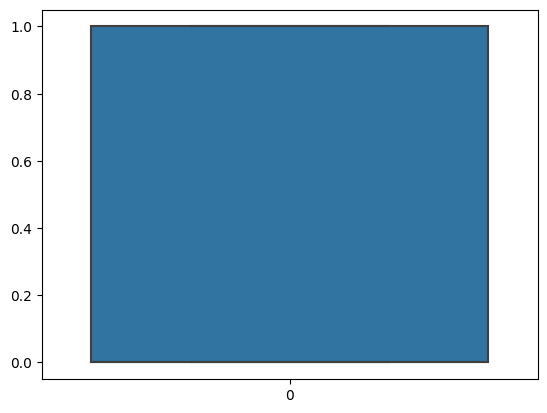

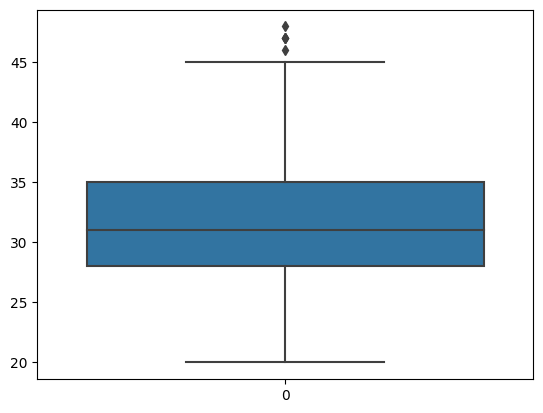

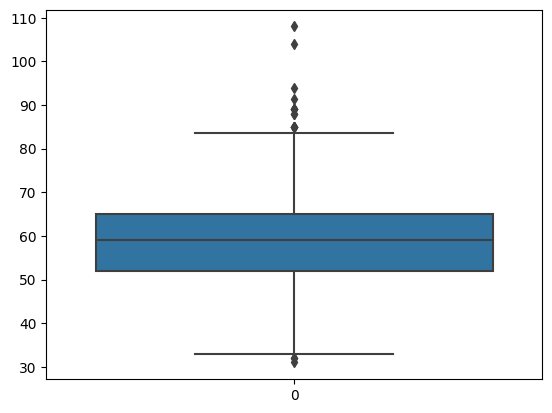

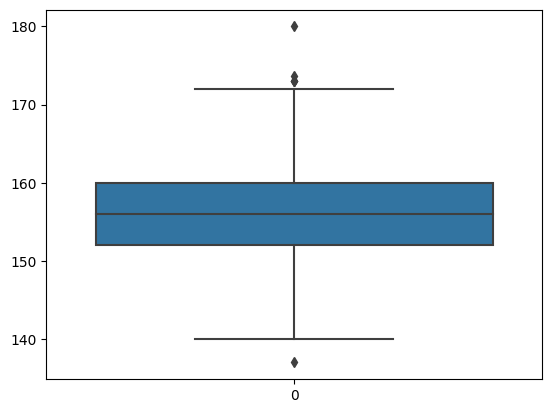

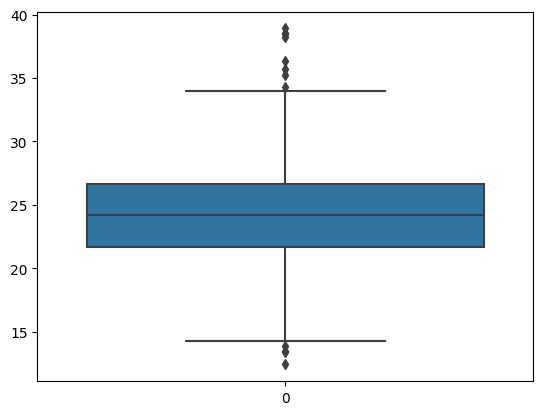

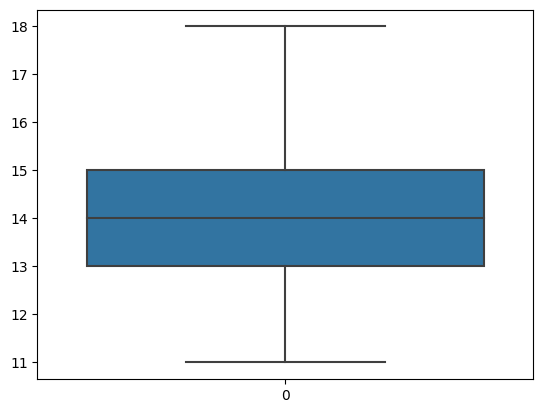

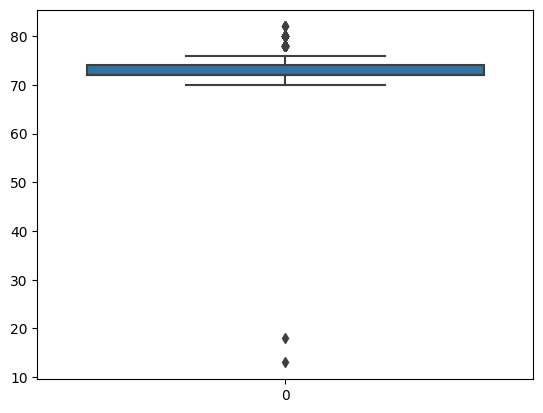

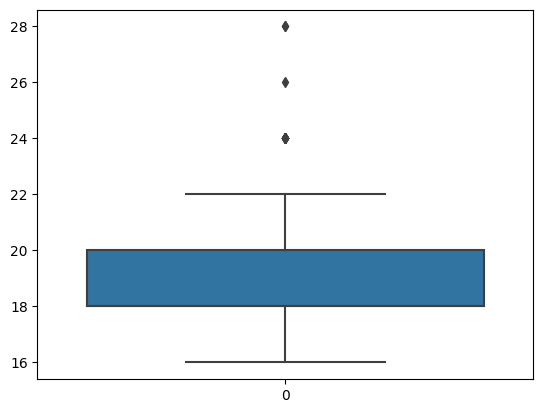

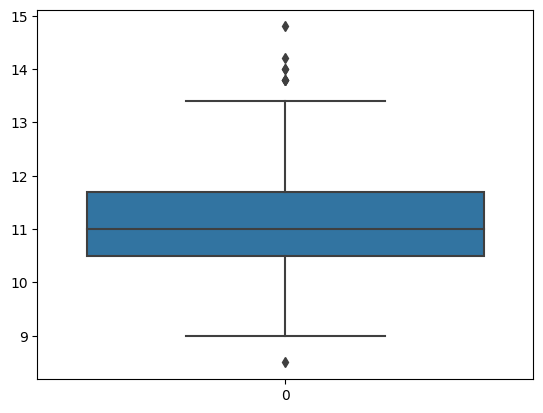

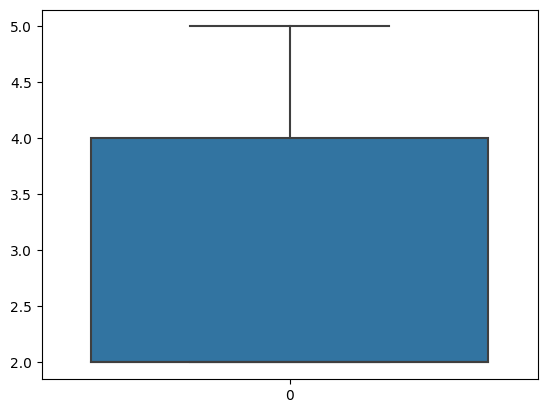

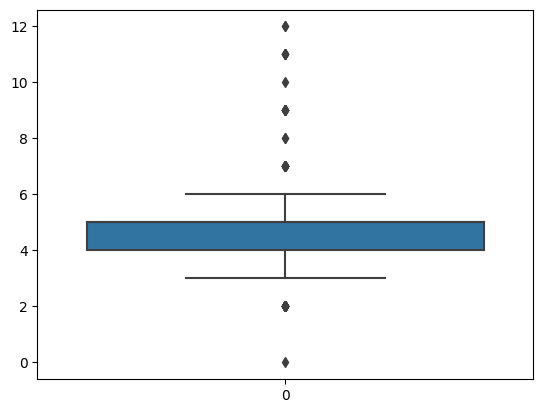

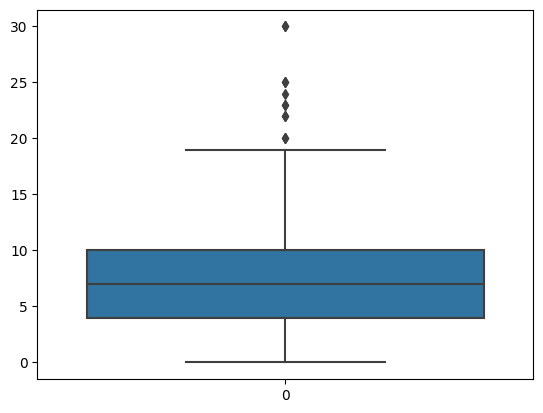

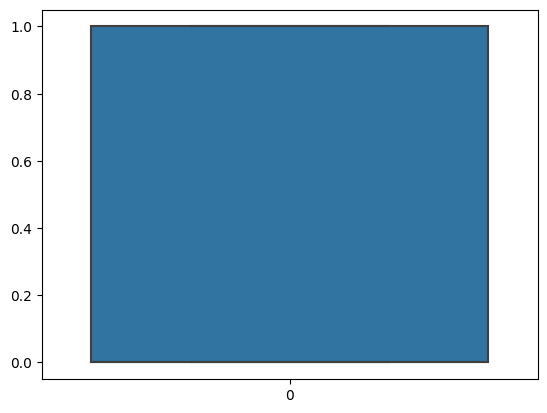

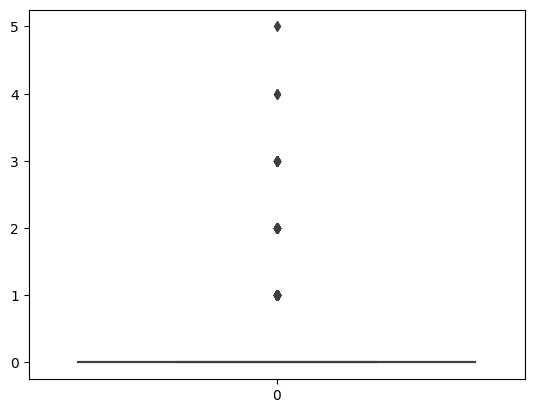

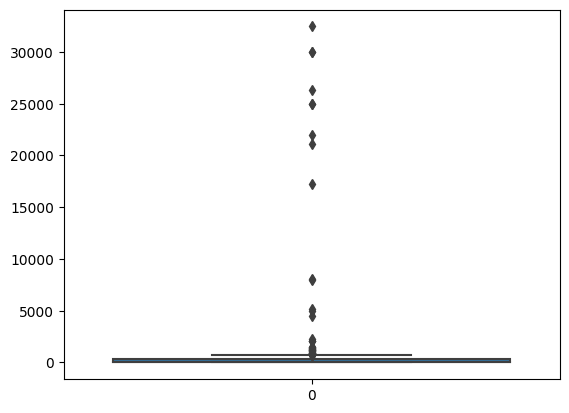

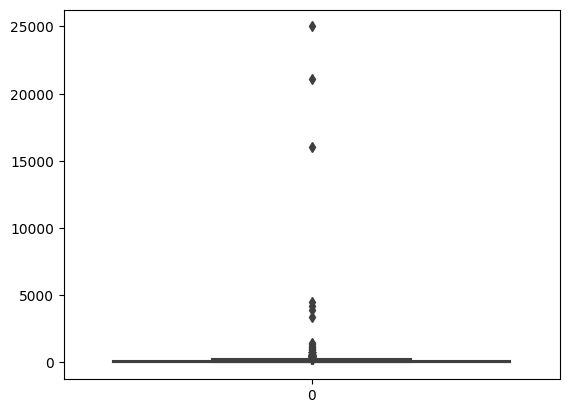

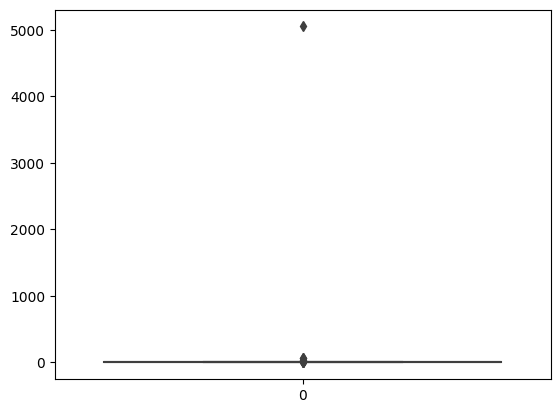

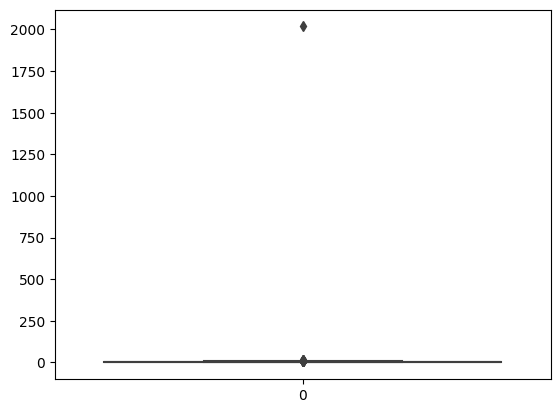

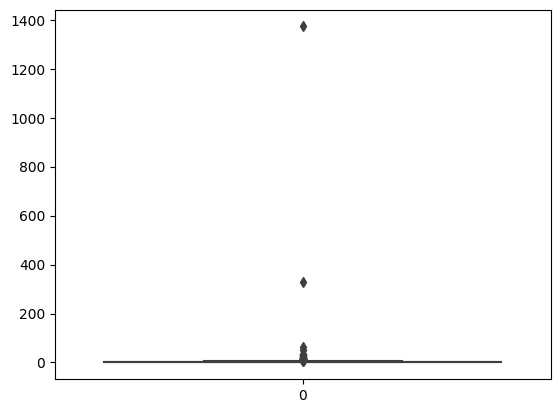

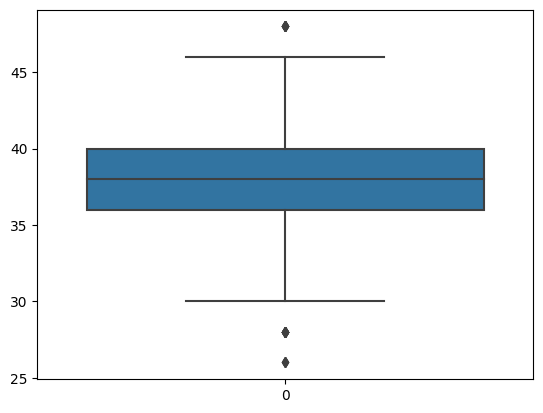

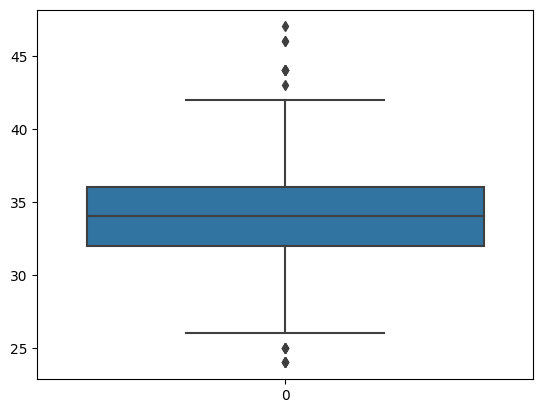

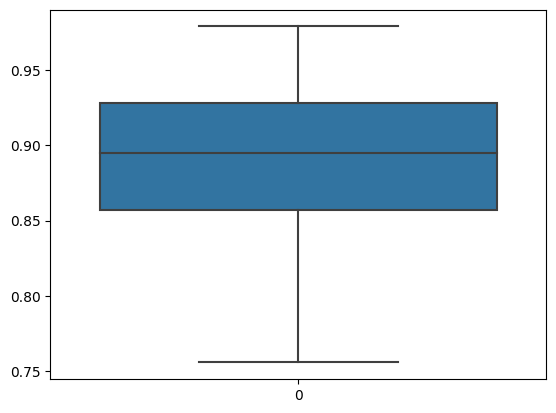

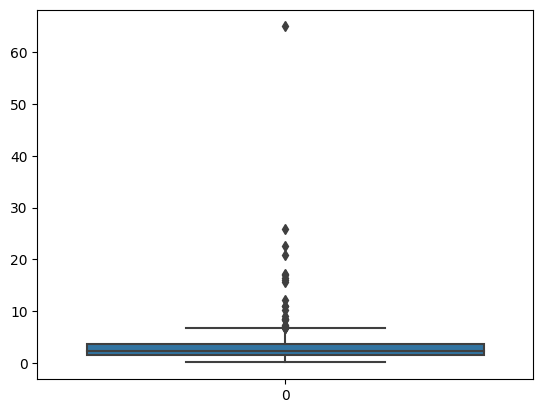

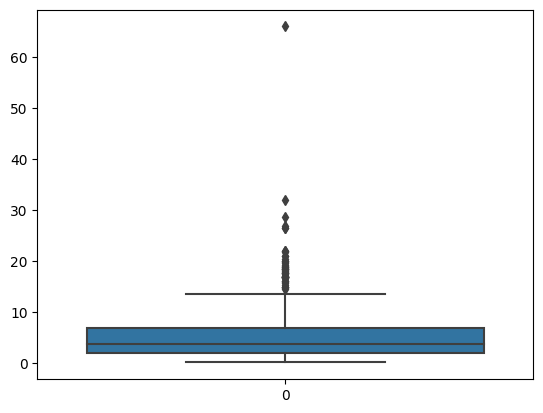

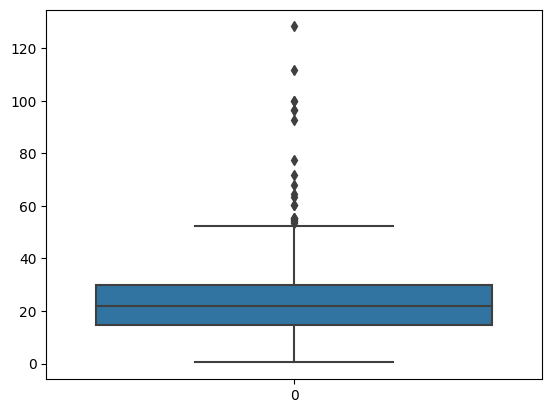

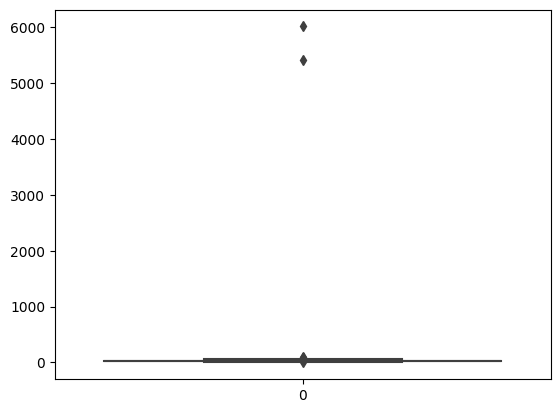

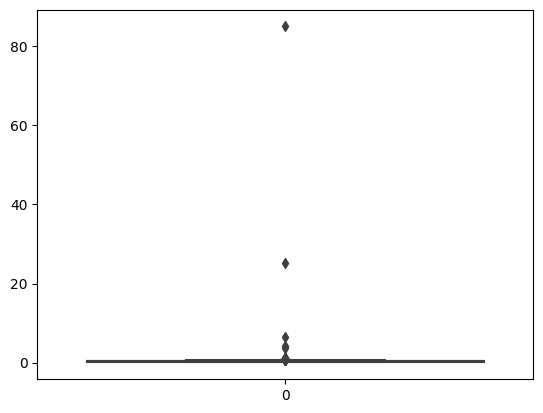

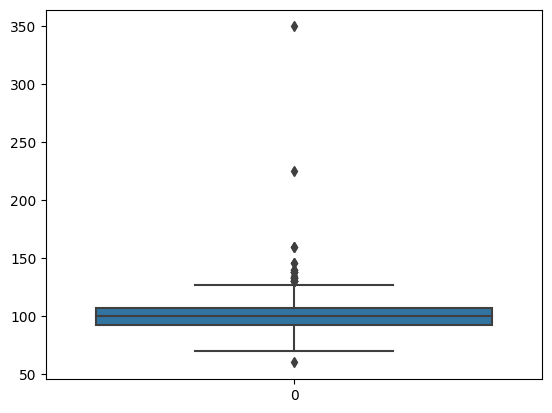

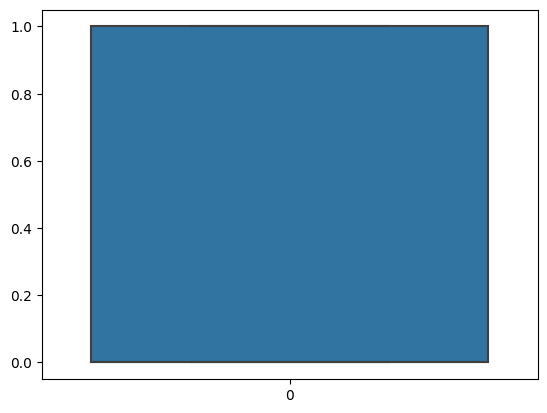

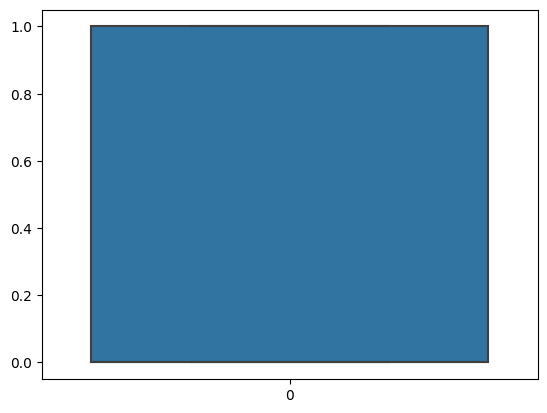

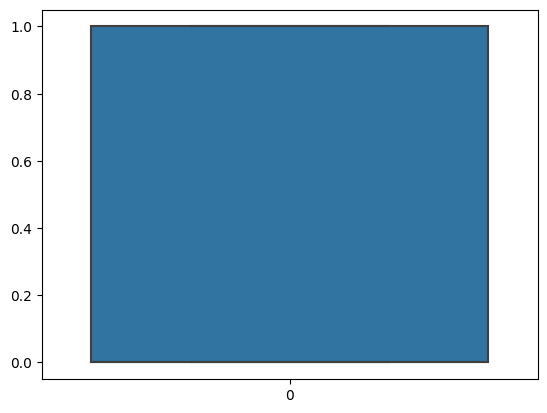

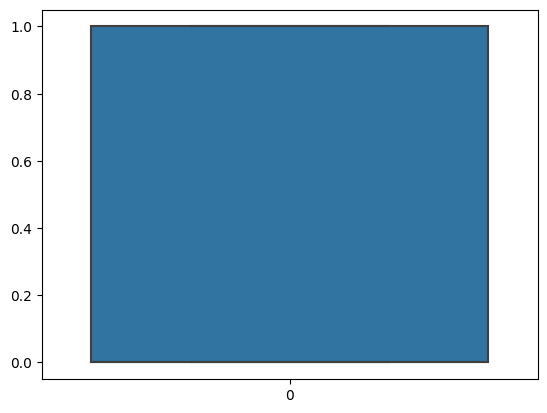

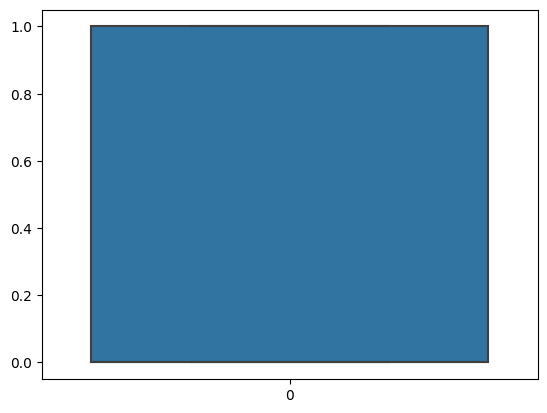

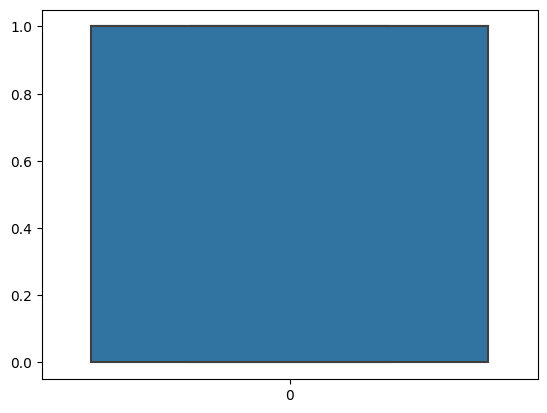

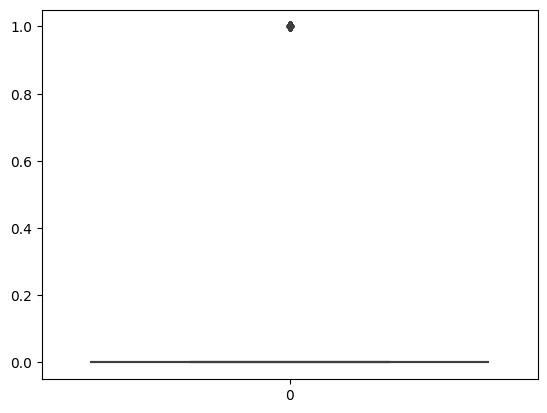

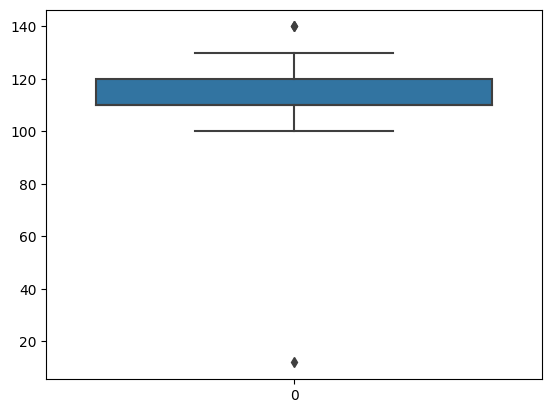

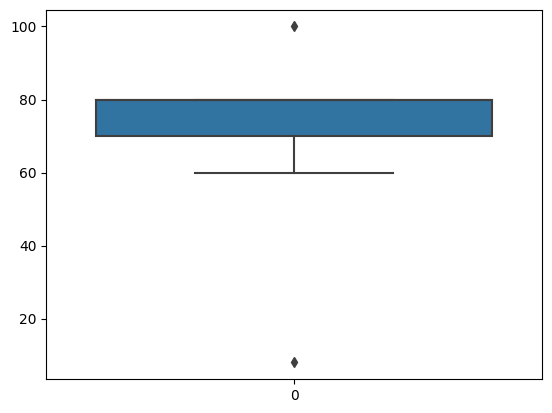

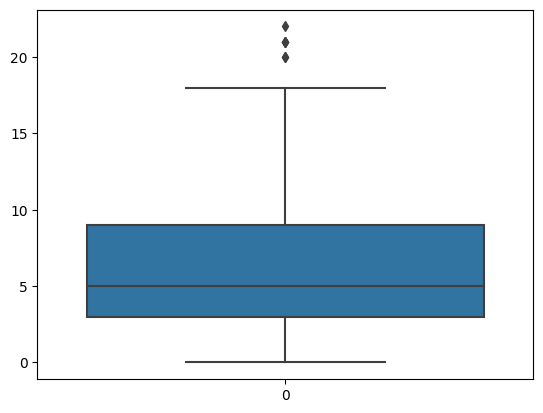

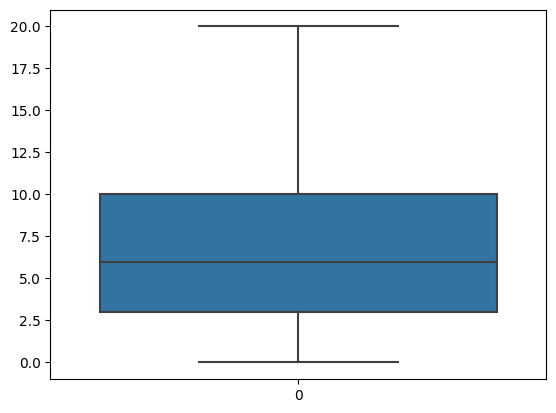

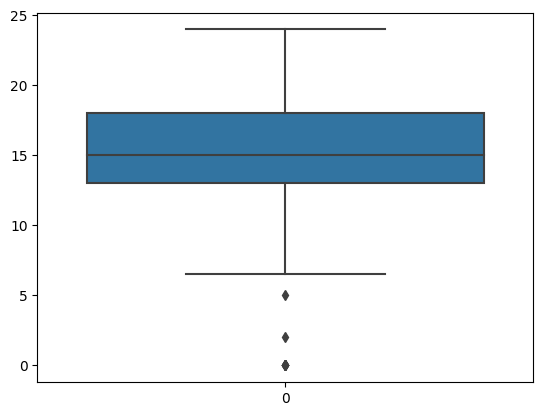

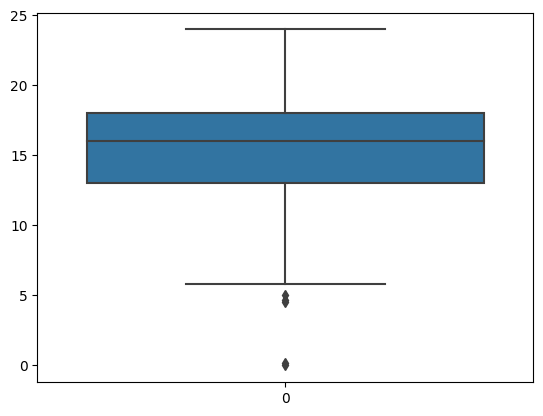

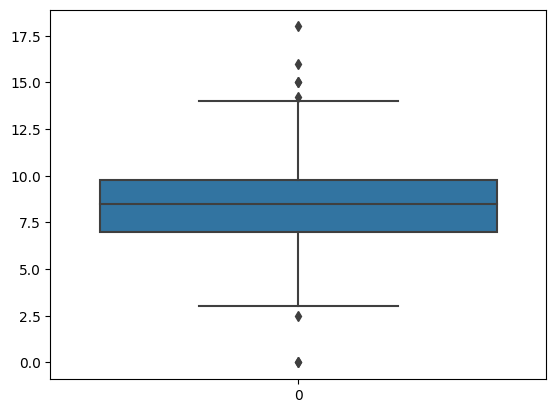

time: 7.52 s (started: 2023-04-04 21:13:23 +00:00)


In [ ]:
for col in df.columns:
  sns.boxplot(df[col])
  plt.show()

We observe the box plots and the type of data of each attribute and decide if it is necessary to remove the outliers in that attribute

In [ ]:
# Listing all the attributes whose outliers needs to be handled
remove_outliers_cols = ['Age (yrs)', 'Weight (Kg)', 'Height(Cm)', 'BMI',
       'Pulse rate(bpm)', 'RR (breaths/min)', 'Hb(g/dl)',
       'Cycle length(days)', 'I   beta-HCG(mIU/mL)',
       'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH',
       'Hip(inch)', 'Waist(inch)', 'TSH (mIU/L)',
       'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)',
       'RBS(mg/dl)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)']

time: 664 µs (started: 2023-04-07 13:05:44 +00:00)


Z-score method:

In [ ]:
# Dimension/shape of dataset before removal of outliers
df.shape

(541, 42)

time: 2.47 ms (started: 2023-04-05 11:19:20 +00:00)


In [ ]:
# Define a threshold for outlier detection
threshold = 3

# Array to store indices of all the outliers
all_outlier_indices = np.array([])

# Iterating through all the selected attributes to remove the outliers
for col in remove_outliers_cols:
  # Calculate the z-scores for each data point
  zscores = np.abs(stats.zscore(df[col]))

  # Find the indices of the data points with z-scores above the threshold
  all_outlier_indices = np.concatenate((all_outlier_indices, np.where(zscores > threshold)[0]))

# storing only unique indices
all_outlier_indices = np.unique(all_outlier_indices)

# Remove the outlier data points
df.drop(all_outlier_indices,inplace = True)

time: 38.2 ms (started: 2023-04-07 13:05:51 +00:00)


In [ ]:
# Dimension/shape of dataset after removal of outliers
df.shape

(440, 42)

time: 3.23 ms (started: 2023-04-05 11:19:25 +00:00)


IQR method: 

Do not use as it is reducing data very drastically

In [ ]:
# Dimension/shape of dataset before removal of outliers
df.shape

(440, 42)

time: 2.86 ms (started: 2023-04-04 14:05:18 +00:00)


In [ ]:
# Array to store indices of all the outliers
all_outlier_indices = np.array([])

# Iterating through all the selected attributes to remove the outliers
for col in remove_outliers_cols:
  # Calculate the first and third quartiles
  q1, q3 = np.percentile(df[col], [25, 75])

  # Calculate the IQR
  iqr = q3 - q1

  # Define a range for outlier detection
  lower_bound = q1 - (1.5 * iqr)
  upper_bound = q3 + (1.5 * iqr)

  # Find the indices of the data points outside the permissible range
  all_outlier_indices = np.concatenate((all_outlier_indices, np.where((df[col] < lower_bound) | (df[col] > upper_bound))[0]))

# storing only unique indices
all_outlier_indices = np.unique(all_outlier_indices)

# Remove the outlier data points
df.drop(all_outlier_indices,inplace = True)

In [ ]:
# Dimension/shape of dataset after removal of outliers
df.shape

(440, 42)

time: 2.7 ms (started: 2023-04-04 14:06:02 +00:00)


## Exploratory Data Analysis

In [ ]:
# Having a look at some basic statistical details.
df.describe()

,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,11.160037,2.560074,...,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,0.866904,0.901950,...,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,8.500000,2.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,10.500000,2.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,11.000000,2.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,11.700000,4.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,14.800000,5.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


time: 117 ms (started: 2023-04-04 21:13:31 +00:00)


### Plot of continuous variables

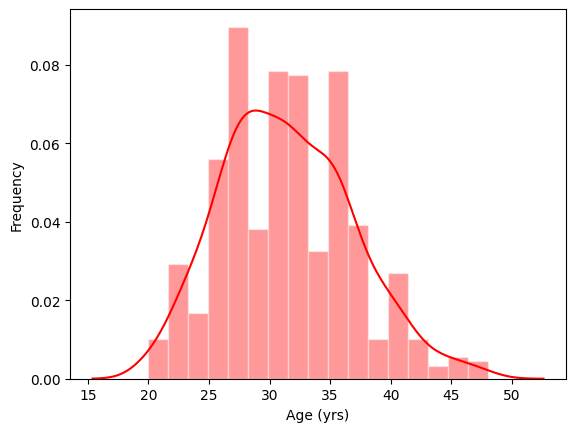

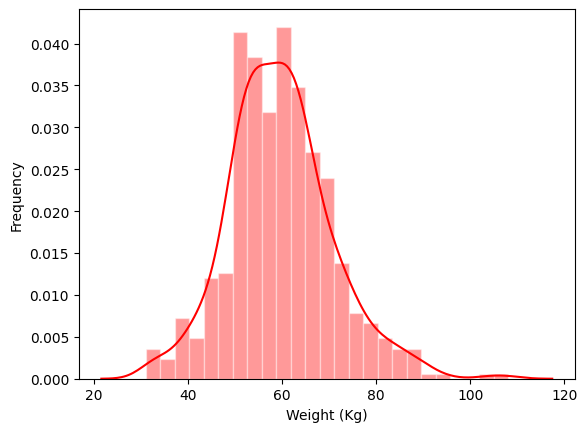

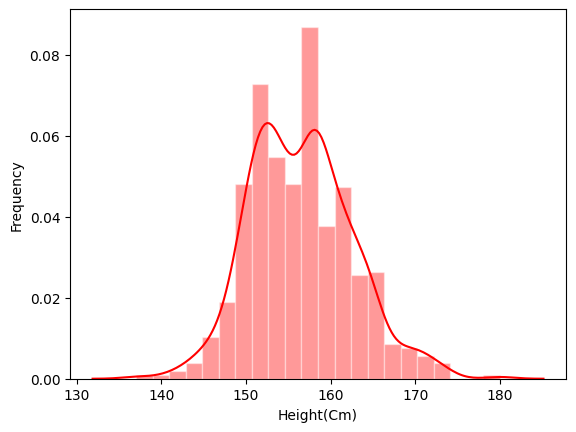

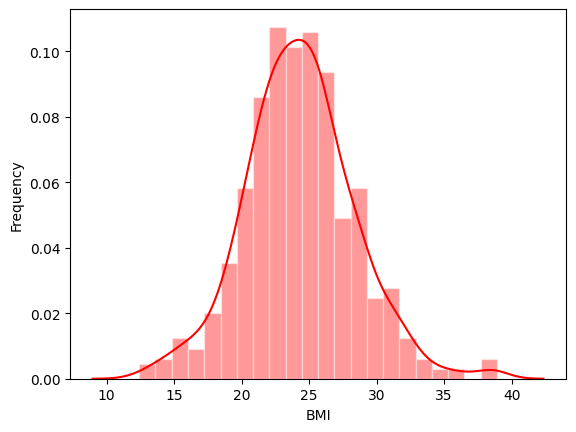

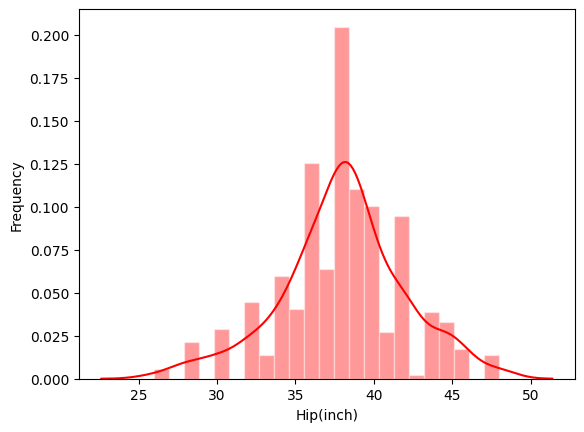

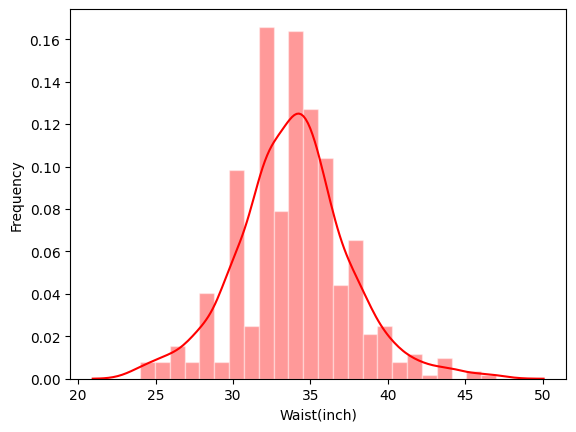

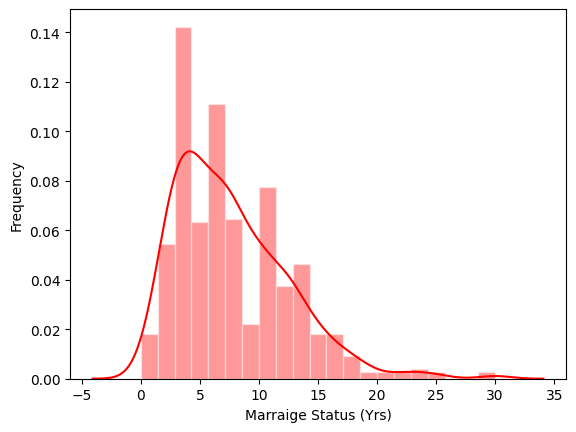

time: 5.2 s (started: 2023-04-04 21:13:31 +00:00)


In [ ]:
continuous_cols=["Age (yrs)", "Weight (Kg)", "Height(Cm)", "BMI", "Hip(inch)", "Waist(inch)", "Marraige Status (Yrs)"]
for i, col in enumerate(continuous_cols):
    plt.figure(i)
    ax=sns.distplot(a=df[col], color='red', hist_kws={"edgecolor": 'white'})
    ax.set(xlabel=col, ylabel='Frequency')

### Plot of categorical variables

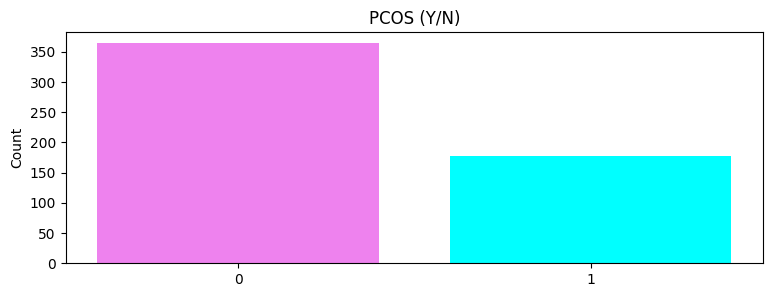

PCOS (Y/N): 
 0    364
1    177
Name: PCOS (Y/N), dtype: int64


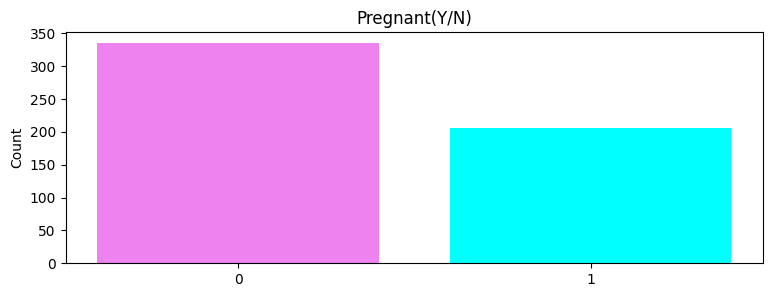

Pregnant(Y/N): 
 0    335
1    206
Name: Pregnant(Y/N), dtype: int64


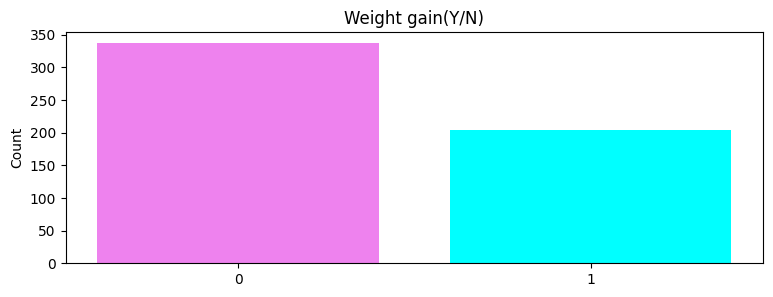

Weight gain(Y/N): 
 0    337
1    204
Name: Weight gain(Y/N), dtype: int64


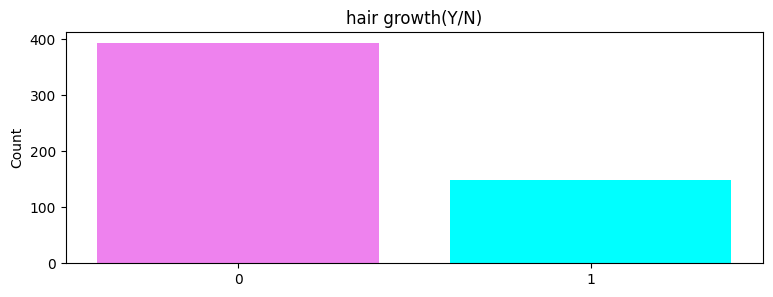

hair growth(Y/N): 
 0    393
1    148
Name: hair growth(Y/N), dtype: int64


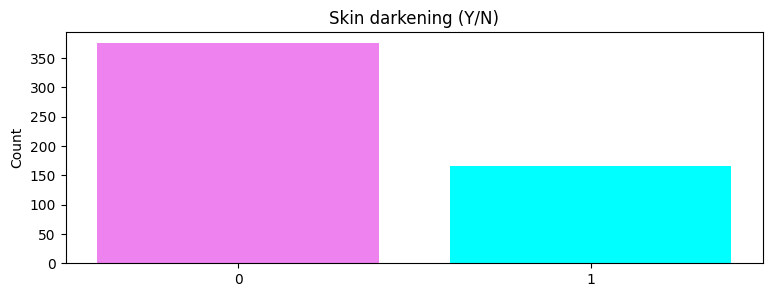

Skin darkening (Y/N): 
 0    375
1    166
Name: Skin darkening (Y/N), dtype: int64


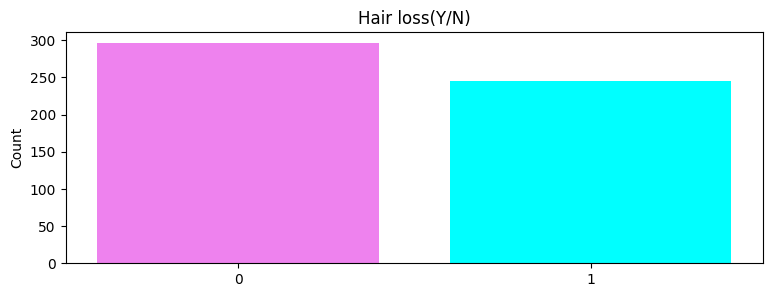

Hair loss(Y/N): 
 0    296
1    245
Name: Hair loss(Y/N), dtype: int64


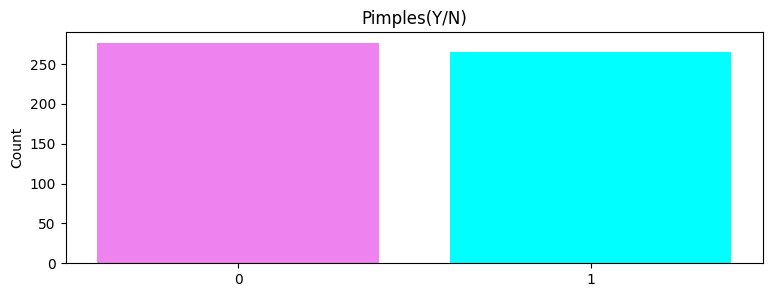

Pimples(Y/N): 
 0    276
1    265
Name: Pimples(Y/N), dtype: int64


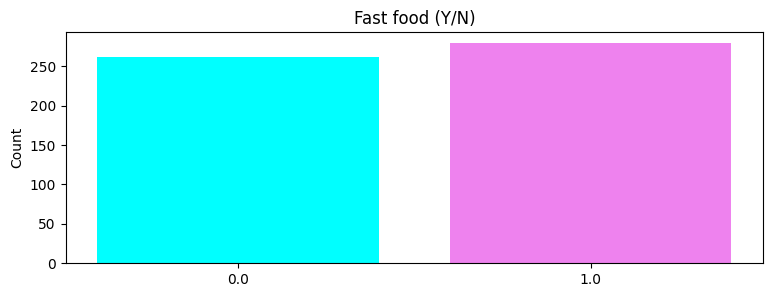

Fast food (Y/N): 
 1.0    279
0.0    262
Name: Fast food (Y/N), dtype: int64


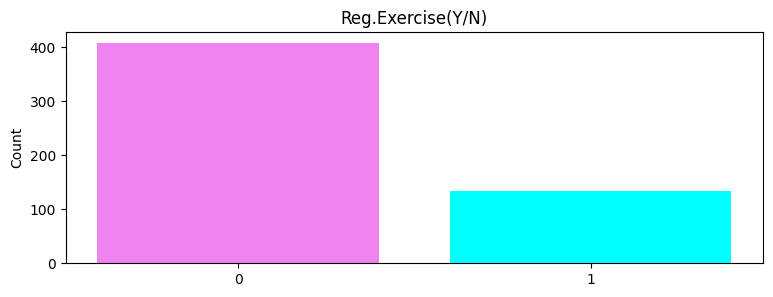

Reg.Exercise(Y/N): 
 0    407
1    134
Name: Reg.Exercise(Y/N), dtype: int64


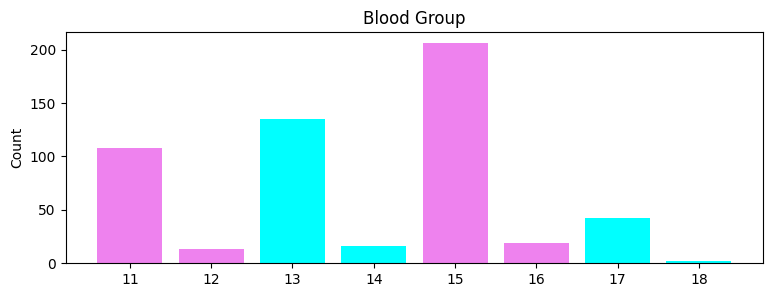

Blood Group: 
 15    206
13    135
11    108
17     42
16     19
14     16
12     13
18      2
Name: Blood Group, dtype: int64
time: 5.01 s (started: 2023-04-04 21:13:36 +00:00)


In [ ]:
category = ["PCOS (Y/N)", "Pregnant(Y/N)", "Weight gain(Y/N)", "hair growth(Y/N)", "Skin darkening (Y/N)", "Hair loss(Y/N)", 
            "Pimples(Y/N)", "Fast food (Y/N)", "Reg.Exercise(Y/N)", "Blood Group"]
for variable in category:
    var = df[variable]
    varValue = var.value_counts()
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index,varValue,color=['violet','cyan'])
    plt.xticks(varValue.index,varValue.index.values)
    plt.ylabel("Count")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))

### Patterns Of Length Of The Menstrual Cycle

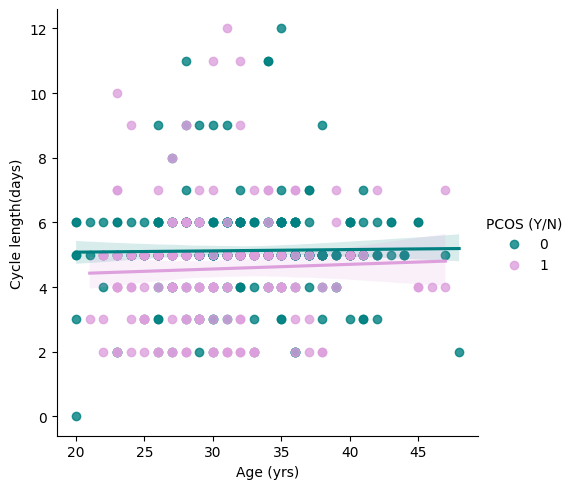

time: 1.4 s (started: 2023-04-04 21:13:41 +00:00)


In [ ]:
# Length of menstrual phase in PCOS vs normal 
color = ["teal", "plum"]
fig=sns.lmplot(data=df,x="Age (yrs)",y="Cycle length(days)", hue="PCOS (Y/N)",palette=color)
plt.show(fig)

The length of the menstrual phase is overall consistent over different ages for normal cases. Whereas in the case of PCOD the length increased with age.

### Patterns Of BMI



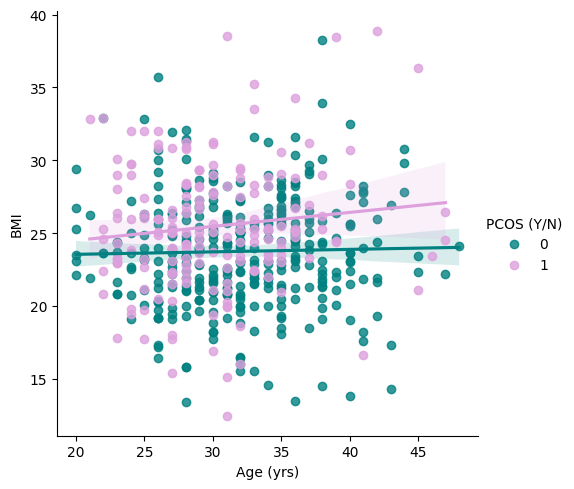

time: 1.81 s (started: 2023-04-04 21:13:43 +00:00)


In [ ]:
# Pattern of weight gain (BMI) over years in PCOS and Normal. 
fig= sns.lmplot(data =df,x="Age (yrs)",y="BMI", hue="PCOS (Y/N)", palette= color )
plt.show(fig)

Body mass index (BMI) is showing consistency for normal cases. Whereas for PCOS the BMI increases with age.



### Patterns Of Irregularity In Mensuration

There is no clarity on what this feature and its values indicate but,

Apparently in the feature "Cycle(R/I)" value:

4 indicates irregular menstrual cycle

2 indicates a regular menstrual cycle



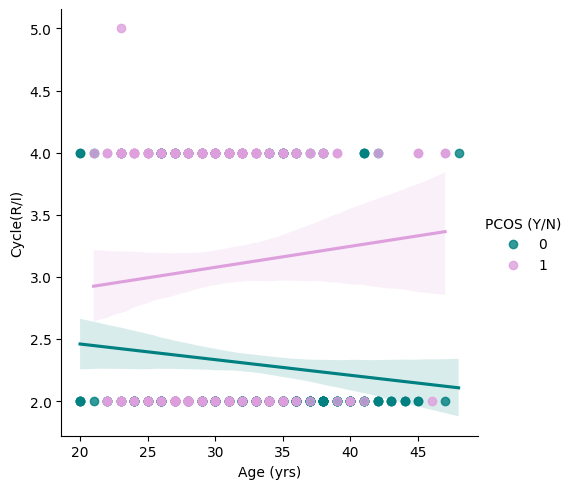

time: 2.98 s (started: 2023-04-04 21:13:45 +00:00)


In [ ]:
# cycle IR wrt age 
sns.lmplot(data =df,x="Age (yrs)",y="Cycle(R/I)", hue="PCOS (Y/N)",palette=color)
plt.show()

The mensural cycle becomes more regular for normal cases with age. Whereas, for PCOS the irregularity increases with age.

### Number Of Follicles



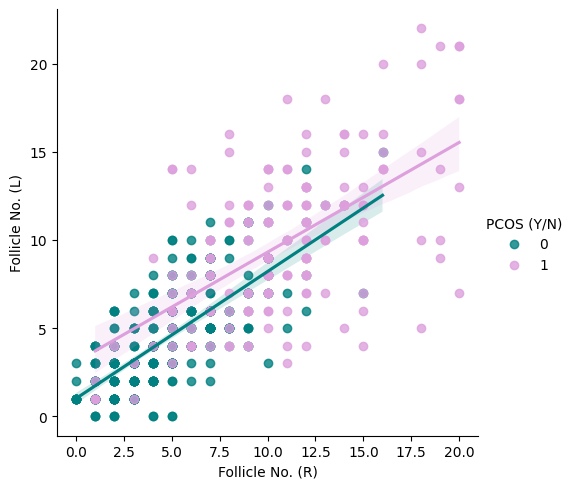

time: 1.59 s (started: 2023-04-04 21:13:48 +00:00)


In [ ]:
# Distribution of follicles in both ovaries. 
sns.lmplot(data =df,x='Follicle No. (R)',y='Follicle No. (L)', hue="PCOS (Y/N)",palette=color)
plt.show()

The distribution of follicles in both ovaries Left and Right are not equal for women with PCOS in comparison with the "Normal" patient. This is curious let's exlore it with boxen plot.

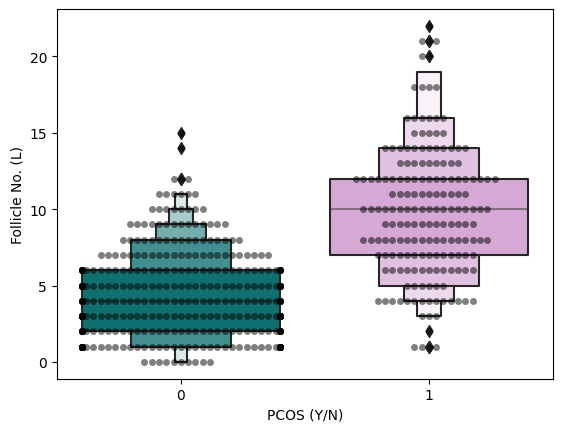

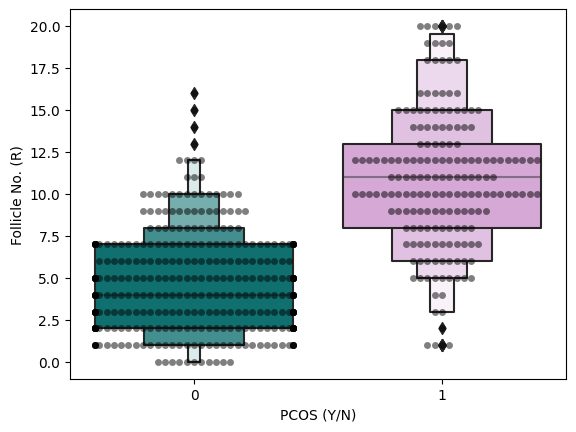

time: 11.3 s (started: 2023-04-04 21:13:49 +00:00)


In [ ]:
features = ["Follicle No. (L)","Follicle No. (R)"]
for i in features:
    sns.swarmplot(x=df["PCOS (Y/N)"], y=df[i], color="black", alpha=0.5 )
    sns.boxenplot(x=df["PCOS (Y/N)"], y=df[i], palette=color)
    plt.show()

The number of follicles in women with PCOS is higher, as expected. And are unequal as well.

### Some Miscellaneous EDA

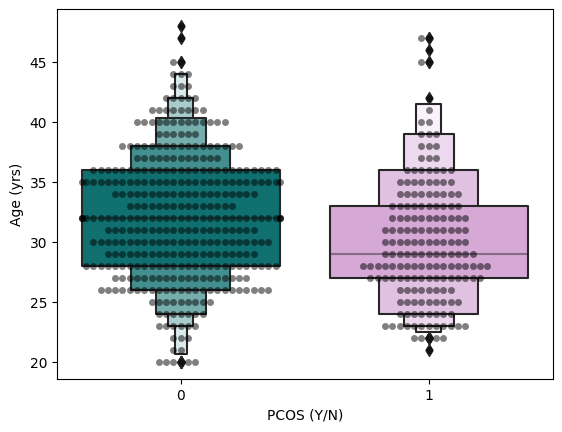

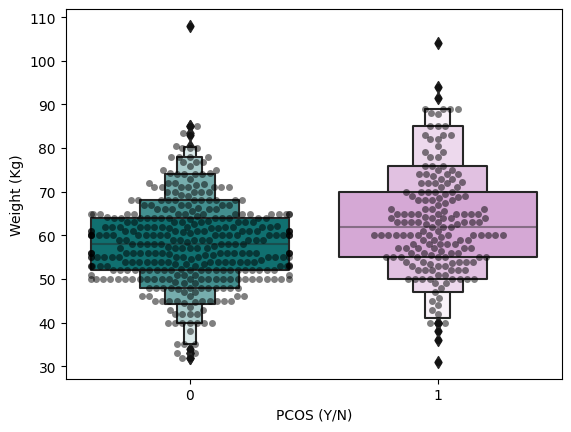

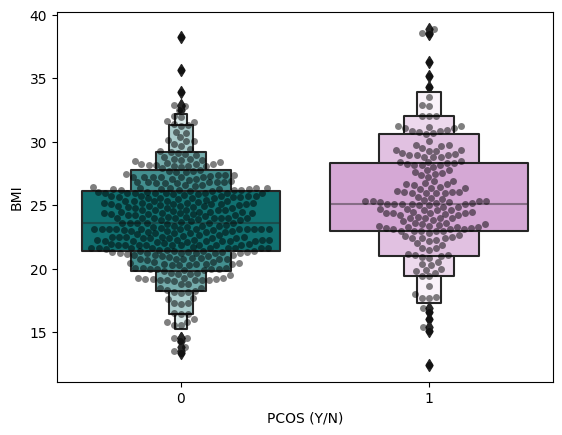

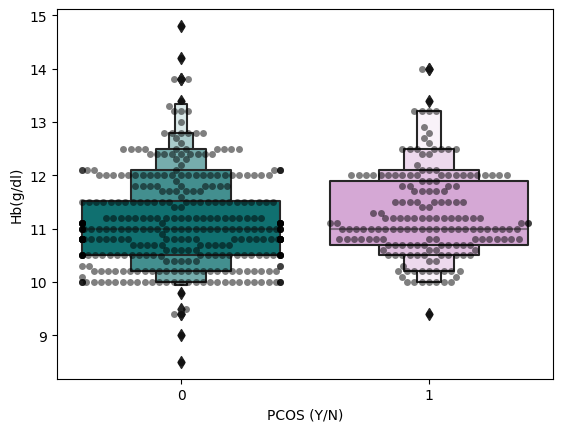

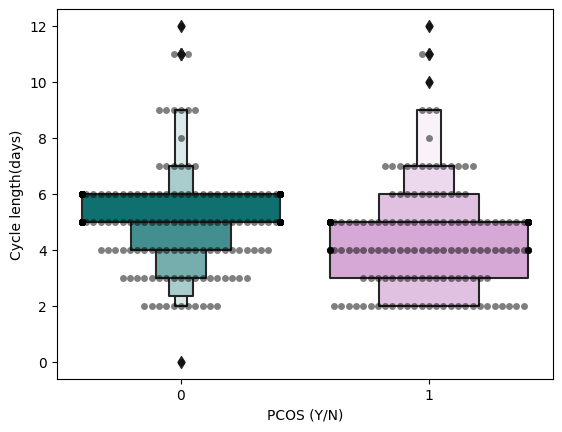

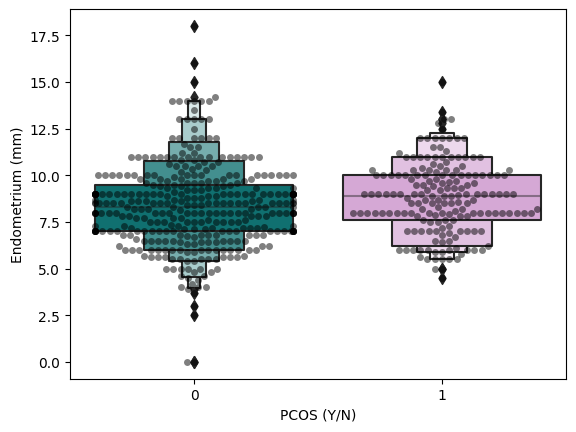

time: 32 s (started: 2023-04-04 21:14:00 +00:00)


In [ ]:
features = ["Age (yrs)","Weight (Kg)", "BMI", "Hb(g/dl)", "Cycle length(days)","Endometrium (mm)" ]
for i in features:
    sns.swarmplot(x=df["PCOS (Y/N)"], y=df[i], color="black", alpha=0.5 )
    sns.boxenplot(x=df["PCOS (Y/N)"], y=df[i], palette=color)
    plt.show()

## Model Building

In [22]:
X = df.drop(labels = ["PCOS (Y/N)"],axis = 1)
y = df['PCOS (Y/N)']

time: 0 ns (started: 2023-04-09 23:53:20 +05:30)


In [23]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

time: 0 ns (started: 2023-04-09 23:53:20 +05:30)


In [24]:
# Scaling data to use wherever necessary

# normalizer = MinMaxScaler()
standardizer = StandardScaler()
X_standardized = standardizer.fit_transform(X)
X_train_standardized = standardizer.fit_transform(X_train)
X_test_standardized = standardizer.fit_transform(X_test)

time: 0 ns (started: 2023-04-09 23:53:20 +05:30)


### Applying Lazy Predict

In [25]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.
time: 3 s (started: 2023-04-09 23:53:23 +05:30)


In [26]:
from lazypredict.Supervised import LazyClassifier

time: 1.64 s (started: 2023-04-09 23:53:26 +05:30)


In [ ]:
import random
random.seed(101)

time: 583 µs (started: 2023-04-07 06:33:32 +00:00)


In [ ]:
# Unscaled Data
lz_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = lz_clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████| 29/29 [00:03<00:00,  8.61it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.89               0.86     0.86      0.89   
BaggingClassifier                  0.88               0.86     0.86      0.88   
Perceptron                         0.87               0.85     0.85      0.87   
XGBClassifier                      0.88               0.85     0.85      0.88   
SGDClassifier                      0.88               0.85     0.85      0.88   
RandomForestClassifier             0.88               0.85     0.85      0.88   
SVC                                0.89               0.84     0.84      0.89   
NearestCentroid                    0.87               0.84     0.84      0.87   
AdaBoostClassifier                 0.87               0.84     0.84      0.87   
ExtraTreesClassifier               0.89               0.84     0.84      0.88   
BernoulliNB                 

In [ ]:
# Scaled Data
lz_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = lz_clf.fit(X_train_standardized, X_test_standardized, y_train, y_test)
print(models)

100%|██████████| 29/29 [00:01<00:00, 16.24it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LinearDiscriminantAnalysis         0.90               0.88     0.88      0.90   
RidgeClassifier                    0.90               0.88     0.88      0.90   
LogisticRegression                 0.90               0.88     0.88      0.90   
RidgeClassifierCV                  0.89               0.87     0.87      0.89   
ExtraTreesClassifier               0.91               0.87     0.87      0.91   
LGBMClassifier                     0.88               0.87     0.87      0.88   
SGDClassifier                      0.87               0.86     0.86      0.87   
XGBClassifier                      0.88               0.86     0.86      0.88   
NearestCentroid                    0.86               0.85     0.85      0.86   
RandomForestClassifier             0.88               0.85     0.85      0.88   
LinearSVC                   

### Applying all algorithms without feature selection

#### Hyperparameter Tuning

In [ ]:
# Logistic Regression
lr_clf = LogisticRegression()

#Building a dictionalry with list of optional values that will be analysed by GridSearchCV
parameters = { 
    'penalty' : ['l1','l2'], 
    'C' : np.logspace(-3,3,7),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    'max_iter' : [100, 500, 1500, 2000],
    'class_weight' : ['None', 'balanced']
}

#Fitting the training set to find parameters with best accuracy
best_lr_clf = GridSearchCV(estimator=lr_clf, param_grid=parameters, cv= 5, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_lr_clf.fit(X_train_standardized, y_train)



#Getting the outcome of gridsearchcv
best_lr_clf_params = best_lr_clf.best_params_
print(best_lr_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_lr_clf.best_estimator_.predict(X_test_standardized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_lr_clf.best_estimator_.score(X_train_standardized, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_lr_clf.best_estimator_.score(X_test_standardized, y_test)*100))

Fitting 5 folds for each of 560 candidates, totalling 2800 fits
{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 88.34%
Accuracy on Training Data: 92.33%
Accuracy on Testing Data: 88.34%
time: 1min 14s (started: 2023-04-05 17:09:13 +00:00)


In [ ]:
# AdaBoost Classifier
ada_clf = AdaBoostClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'n_estimators' : [10, 50, 100, 500],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

#Fitting the training set to find parameters with best accuracy
best_ada_clf = GridSearchCV(estimator=ada_clf, param_grid=parameters, cv= 5, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_ada_clf.fit(X_train, y_train)

#Getting the outcome of gridsearchcv
best_ada_clf_params = best_ada_clf.best_params_
print(best_ada_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_ada_clf.best_estimator_.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_ada_clf.best_estimator_.score(X_train, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_ada_clf.best_estimator_.score(X_test, y_test)*100))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 500}
Accuracy: 87.73%
Accuracy on Training Data: 98.94%
Accuracy on Testing Data: 87.73%
time: 1min 10s (started: 2023-04-05 17:29:20 +00:00)


In [ ]:
# Random Forest
rf_clf = RandomForestClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'bootstrap': [True, False],
    'n_estimators': [200, 500, 800, 1000, 1500, 2000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10, 30, 50, 80, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'criterion' :['gini', 'entropy'],
    'n_jobs':[-1]
}

#Fitting the training set to find parameters with best accuracy
best_rf_clf = GridSearchCV(estimator=rf_clf, param_grid=parameters, cv= 5, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_rf_clf.fit(X_train, y_train)

#Getting the outcome of gridsearchcv
best_rf_clf_params = best_rf_clf.best_params_
print(best_rf_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_rf_clf.best_estimator_.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_rf_clf.best_estimator_.score(X_train, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_rf_clf.best_estimator_.score(X_test, y_test)*100))

In [ ]:
# ExtraTrees Classifier
et_clf = ExtraTreesClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = {
    'n_estimators': [100,200,500,1000,1500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2,8,16,32,50],
    'min_samples_split': [2,4,6],
    'min_samples_leaf': [1,2],
    #'oob_score': [True, False],
    'max_features': ['sqrt','log2','None'],    
    'bootstrap': [True, False],
    'warm_start': [True, False],
}

#Fitting the training set to find parameters with best accuracy
best_et_clf = GridSearchCV(estimator=et_clf, param_grid=parameters, cv= 5, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_et_clf.fit(X_train, y_train)

#Getting the outcome of gridsearchcv
best_et_clf_params = best_et_clf.best_params_
print(best_et_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_et_clf.best_estimator_.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_et_clf.best_estimator_.score(X_train, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_et_clf.best_estimator_.score(X_test, y_test)*100))

In [ ]:
# MLP Classifier
mlp_clf = MLPClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': 10.0 ** -np.arange(1, 7),
    'max_iter': [400, 800, 1500, 2000],
    'hidden_layer_sizes': [(25, 50), (25, 50, 100)], 
    'random_state': [0,1,2,5,9],
    'learning_rate': ["constant", "invscaling", "adaptive"]
}

#Fitting the training set to find parameters with best accuracy
best_mlp_clf = GridSearchCV(estimator=mlp_clf, param_grid=parameters, cv= 5, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_mlp_clf.fit(X_train_standardized, y_train)

#Getting the outcome of gridsearchcv
best_mlp_clf_params = best_mlp_clf.best_params_
print(best_mlp_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_mlp_clf.best_estimator_.predict(X_test_standardized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_mlp_clf.best_estimator_.score(X_train_standardized, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_mlp_clf.best_estimator_.score(X_test_standardized, y_test)*100))

In [ ]:
# Linear SVC
svm_clf = SVC()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'], 
    'degree' : [1,2,3,4,5,6], 
    'class_weight' : ['None', 'balanced']
}

#Fitting the training set to find parameters with best accuracy
best_svm_clf = GridSearchCV(estimator=svm_clf, param_grid=parameters, cv= 5, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_svm_clf.fit(X_train_standardized, y_train)

#Getting the outcome of gridsearchcv
best_svm_clf_params = best_svm_clf.best_params_
print(best_svm_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_svm_clf.best_estimator_.predict(X_test_standardized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_svm_clf.best_estimator_.score(X_train_standardized, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_svm_clf.best_estimator_.score(X_test_standardized, y_test)*100))

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
{'C': 10, 'class_weight': 'balanced', 'degree': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 87.12%
Accuracy on Training Data: 91.80%
Accuracy on Testing Data: 87.12%
time: 31min 7s (started: 2023-04-05 17:30:30 +00:00)


In [ ]:
# K Nearest Neighbors Classifier
knn_clf = KNeighborsClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'n_neighbors' : list(range(2,31,2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': list(range(20,41,3)),
    'p': [1, 2]
}

#Fitting the training set to find parameters with best accuracy
best_knn_clf = GridSearchCV(estimator=knn_clf, param_grid=parameters, cv= 5, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_knn_clf.fit(X_train_standardized, y_train)

#Getting the outcome of gridsearchcv
best_knn_clf_params = best_knn_clf.best_params_
print(best_knn_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_knn_clf.best_estimator_.predict(X_test_standardized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_knn_clf.best_estimator_.score(X_train_standardized, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_knn_clf.best_estimator_.score(X_test_standardized, y_test)*100))

Fitting 3 folds for each of 5040 candidates, totalling 15120 fits
{'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Accuracy: 88.34%
Accuracy on Training Data: 100.00%
Accuracy on Testing Data: 88.34%
time: 1min 34s (started: 2023-04-05 18:15:46 +00:00)


In [ ]:
# Stochastic Gradient Descent Classifier
sgd_clf = SGDClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    "loss" : ["hinge", "log_loss", "squared_hinge", "modified_huber", "perceptron"],
    "penalty" : ["l2", "l1", "none", "elasticnet"],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1]
}

#Fitting the training set to find parameters with best accuracy
best_sgd_clf = GridSearchCV(estimator=sgd_clf, param_grid=parameters, cv= 5, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_sgd_clf.fit(X_train_standardized, y_train)

#Getting the outcome of gridsearchcv
best_sgd_clf_params = best_sgd_clf.best_params_
print(best_sgd_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_sgd_clf.best_estimator_.predict(X_test_standardized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_sgd_clf.best_estimator_.score(X_train_standardized, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_sgd_clf.best_estimator_.score(X_test_standardized, y_test)*100))

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits
{'alpha': 0.01, 'l1_ratio': 0.8, 'loss': 'log_loss', 'penalty': 'elasticnet'}
Accuracy: 85.89%
Accuracy on Training Data: 93.65%
Accuracy on Testing Data: 85.89%
time: 21.2 s (started: 2023-04-05 18:37:33 +00:00)


#### Creating Model with Tuned Hyperparameters

In [ ]:
# Create the classifiers
lr_clf = LogisticRegression(**{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}) # done
ada_clf = AdaBoostClassifier(**{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 500}) # done
#rf_clf = RandomForestClassifier(**best_rf_clf_params, random_state=42)
# rf_clf = RandomForestClassifier(**{'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 500, 'n_jobs': None})
rf_clf = RandomForestClassifier()
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
svm_clf = SVC(**{'C': 10, 'class_weight': 'balanced', 'degree': 1, 'gamma': 0.0001, 'kernel': 'rbf'}) # done
knn_clf = KNeighborsClassifier(**{'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}) # done
sgd_clf = SGDClassifier(**{'alpha': 0.01, 'l1_ratio': 0.8, 'loss': 'log_loss', 'penalty': 'elasticnet'}) # done

# Create the ensemble voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr_clf), ('ada', ada_clf), ('rf', rf_clf), ('et', et_clf), ('mlp', mlp_clf), ('svm', svm_clf), ('knn', knn_clf), ('sgd', sgd_clf)],
    voting='hard'
)

time: 2.18 ms (started: 2023-04-07 06:32:06 +00:00)


In [ ]:
# Train the individual classifiers
lr_clf.fit(X_train_standardized, y_train)
ada_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
et_clf.fit(X_train, y_train)
mlp_clf.fit(X_train_standardized, y_train)
svm_clf.fit(X_train_standardized, y_train)
knn_clf.fit(X_train_standardized, y_train)
sgd_clf.fit(X_train_standardized, y_train)

# Train the ensemble voting classifier
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 penalty='l1', solver='saga')),
                             ('ada',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=500)),
                             ('rf', RandomForestClassifier()),
                             ('et', ExtraTreesClassifier(random_state=42)),
                             ('mlp',
                              MLPClassifier(max_iter=1000, random_state=42)),
                             ('svm',
                              SVC(C=10, class_weight='balanced', degree=1,
                                  gamma=0.0001)),
                             ('knn',
                              KNeighborsClassifier(algorithm='ball_tree',
                                                   leaf_size=20,
                                                   metric='manhattan',
                                                   n_neighbors=4, p=1,
                                                   weights='distance')),
                             ('sgd',
                              SGDClassifier(alpha=0.01, l1_ratio=0.8,
                                            loss='log_loss',
                                            penalty='elasticnet'))])

time: 5.38 s (started: 2023-04-07 06:32:06 +00:00)


In [ ]:
# Predict using the individual and ensemble classifiers
y_pred_lr = lr_clf.predict(X_test_standardized)
y_pred_ada = ada_clf.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_et = et_clf.predict(X_test)
y_pred_mlp = mlp_clf.predict(X_test_standardized)
y_pred_svm = svm_clf.predict(X_test_standardized)
y_pred_knn = knn_clf.predict(X_test_standardized)
y_pred_sgd = sgd_clf.predict(X_test_standardized)
y_pred_voting = voting_clf.predict(X_test)

time: 375 ms (started: 2023-04-07 06:32:12 +00:00)


In [ ]:
# Calculate the accuracy of the classifiers
accuracy_lr = accuracy_score(y_test, y_pred_lr)*100
accuracy_ada = accuracy_score(y_test, y_pred_ada)*100
accuracy_rf = accuracy_score(y_test, y_pred_rf)*100
accuracy_et = accuracy_score(y_test, y_pred_et)*100
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)*100
accuracy_svm = accuracy_score(y_test, y_pred_svm)*100
accuracy_knn = accuracy_score(y_test, y_pred_knn)*100
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)*100
accuracy_voting = accuracy_score(y_test, y_pred_voting)*100

time: 8.86 ms (started: 2023-04-07 06:32:12 +00:00)


In [ ]:
print('Logistic Regression accuracy: %.2f' % accuracy_lr)
print('AdaBoost accuracy: %.2f' % accuracy_ada)
print('Random Forest accuracy: %.2f' % accuracy_rf)
print('Extra Trees accuracy: %.2f' % accuracy_et)
print('MLP accuracy: %.2f' % accuracy_mlp)
print('SVM accuracy: %.2f' % accuracy_svm)
print('KNN accuracy: %.2f' % accuracy_knn)
print('SGD accuracy: %.2f' % accuracy_sgd)
print('Ensemble Voting accuracy: %.2f' % accuracy_voting)

Logistic Regression accuracy: 88.34
AdaBoost accuracy: 87.73
Random Forest accuracy: 86.50
Extra Trees accuracy: 88.96
MLP accuracy: 84.66
SVM accuracy: 87.12
KNN accuracy: 88.34
SGD accuracy: 70.55
Ensemble Voting accuracy: 85.28
time: 7.3 ms (started: 2023-04-07 06:32:12 +00:00)


In [ ]:
print('-------------------Logistic Regression accuracy----------------------')
print('Train Data: %.2f' % (lr_clf.score(X_train_standardized, y_train)*100))
print('Test Data: %.2f' % (lr_clf.score(X_test_standardized, y_test)*100))

print('-------------------AdaBoost accuracy----------------------')
print('Train Data: %.2f' % (ada_clf.score(X_train, y_train)*100))
print('Test Data: %.2f' % (ada_clf.score(X_test, y_test)*100))

print('-------------------Random Forest accuracy----------------------')
print('Train Data: %.2f' % (rf_clf.score(X_train, y_train)*100))
print('Test Data: %.2f' % (rf_clf.score(X_test, y_test)*100))

print('-------------------Extra Trees accuracy----------------------')
print('Train Data: %.2f' % (et_clf.score(X_train, y_train)*100))
print('Test Data: %.2f' % (et_clf.score(X_test, y_test)*100))

print('-------------------MLP accuracy----------------------')
print('Train Data: %.2f' % (mlp_clf.score(X_train_standardized, y_train)*100))
print('Test Data: %.2f' % (mlp_clf.score(X_test_standardized, y_test)*100))

print('-------------------SVM accuracy----------------------')
print('Train Data: %.2f' % (svm_clf.score(X_train_standardized, y_train)*100))
print('Test Data: %.2f' % (svm_clf.score(X_test_standardized, y_test)*100))

print('-------------------KNN accuracy----------------------')
print('Train Data: %.2f' % (knn_clf.score(X_train_standardized, y_train)*100))
print('Test Data: %.2f' % (knn_clf.score(X_test_standardized, y_test)*100))

print('-------------------SGD accuracy----------------------')
print('Train Data: %.2f' % (sgd_clf.score(X_train_standardized, y_train)*100))
print('Test Data: %.2f' % (sgd_clf.score(X_test_standardized, y_test)*100))

print('-------------------Ensemble Voting accuracy----------------------')
print('Train Data: %.2f' % (voting_clf.score(X_train, y_train)*100))
print('Test Data: %.2f' % (voting_clf.score(X_test, y_test)*100))

-------------------Logistic Regression accuracy----------------------
Train Data: 92.33
Test Data: 88.34
-------------------AdaBoost accuracy----------------------
Train Data: 98.94
Test Data: 87.73
-------------------Random Forest accuracy----------------------
Train Data: 100.00
Test Data: 86.50
-------------------Extra Trees accuracy----------------------
Train Data: 100.00
Test Data: 88.96
-------------------MLP accuracy----------------------
Train Data: 100.00
Test Data: 84.66
-------------------SVM accuracy----------------------
Train Data: 91.80
Test Data: 87.12
-------------------KNN accuracy----------------------
Train Data: 100.00
Test Data: 88.34
-------------------SGD accuracy----------------------
Train Data: 93.12
Test Data: 70.55
-------------------Ensemble Voting accuracy----------------------
Train Data: 99.47
Test Data: 85.28
time: 801 ms (started: 2023-04-07 06:32:12 +00:00)


-----Logistic Regression-----
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       110
           1       0.79      0.87      0.83        53

    accuracy                           0.88       163
   macro avg       0.86      0.88      0.87       163
weighted avg       0.89      0.88      0.88       163



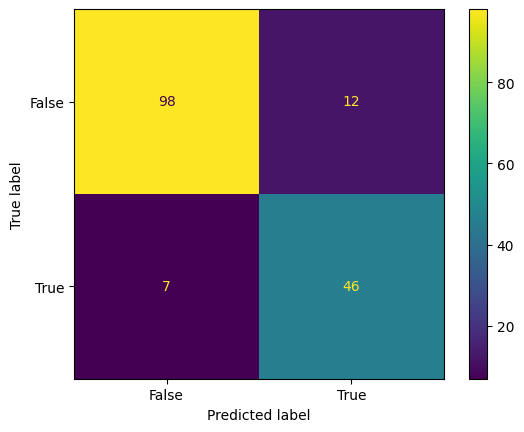

-----AdaBoost-----
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       110
           1       0.85      0.75      0.80        53

    accuracy                           0.88       163
   macro avg       0.87      0.85      0.86       163
weighted avg       0.88      0.88      0.88       163



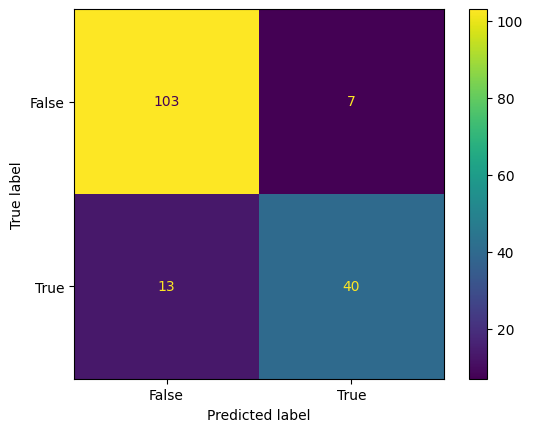

-----Random Forest-----
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       110
           1       0.93      0.72      0.81        53

    accuracy                           0.89       163
   macro avg       0.90      0.84      0.87       163
weighted avg       0.89      0.89      0.89       163



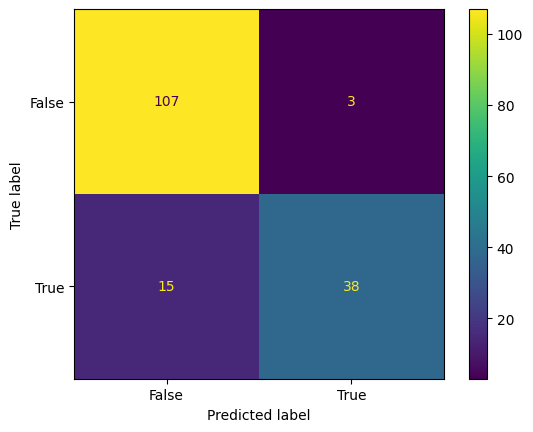

-----ExtraTree-----
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       110
           1       0.95      0.70      0.80        53

    accuracy                           0.89       163
   macro avg       0.91      0.84      0.86       163
weighted avg       0.90      0.89      0.88       163



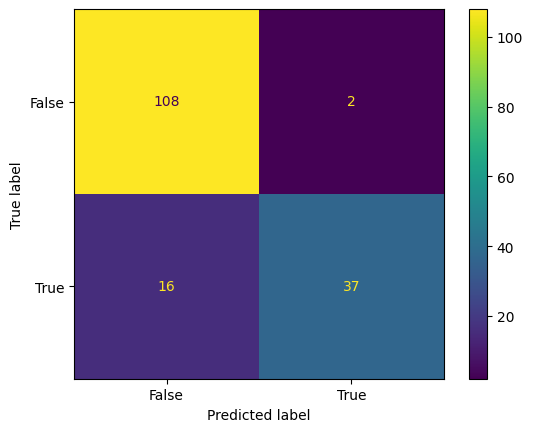

-----Multi-Layer Perceptron-----
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       110
           1       0.77      0.75      0.76        53

    accuracy                           0.85       163
   macro avg       0.83      0.82      0.82       163
weighted avg       0.85      0.85      0.85       163



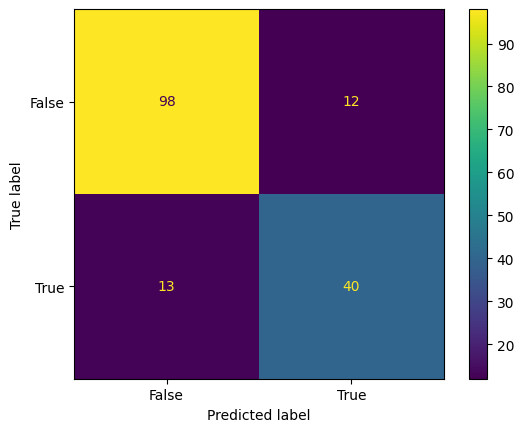

-----Support Vector Machine-----
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       110
           1       0.88      0.66      0.75        53

    accuracy                           0.86       163
   macro avg       0.86      0.81      0.83       163
weighted avg       0.86      0.86      0.85       163



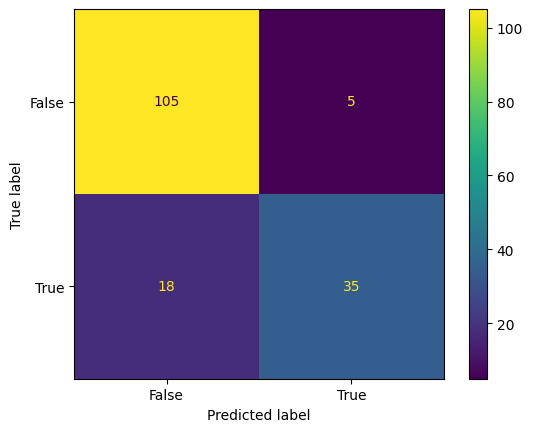

-----K-Nearest Neighbor-----
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       110
           1       0.90      0.70      0.79        53

    accuracy                           0.88       163
   macro avg       0.89      0.83      0.85       163
weighted avg       0.88      0.88      0.87       163



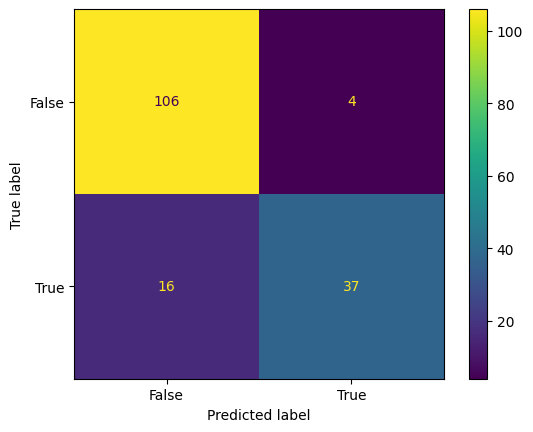

-----Stochastic Gradient Descent-----
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       110
           1       0.66      0.81      0.73        53

    accuracy                           0.80       163
   macro avg       0.78      0.81      0.79       163
weighted avg       0.82      0.80      0.81       163



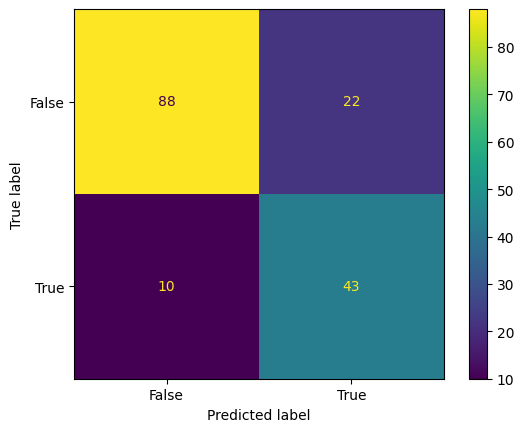

-----Ensemble Voting-----
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       110
           1       0.90      0.51      0.65        53

    accuracy                           0.82       163
   macro avg       0.85      0.74      0.77       163
weighted avg       0.84      0.82      0.81       163



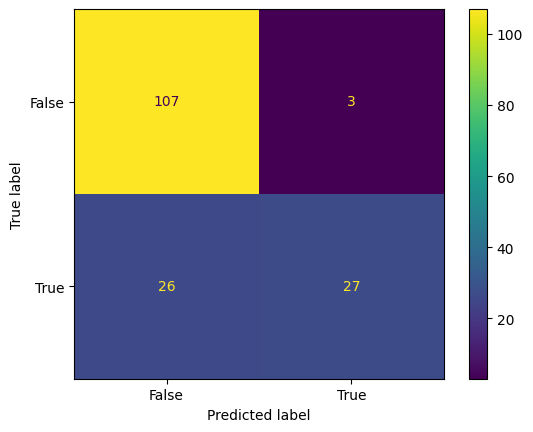

time: 2.98 s (started: 2023-04-04 22:50:12 +00:00)


In [ ]:
print('-----Logistic Regression-----')
classi_report_lr = classification_report(y_test, y_pred_lr)
print(classi_report_lr)
cm = confusion_matrix(y_test, y_pred_lr, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----AdaBoost-----')
classi_report_ada = classification_report(y_test, y_pred_ada)
print(classi_report_ada)
cm = confusion_matrix(y_test, y_pred_ada, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----Random Forest-----')
classi_report_rf = classification_report(y_test, y_pred_rf)
print(classi_report_rf)
cm = confusion_matrix(y_test, y_pred_rf, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----ExtraTree-----')
classi_report_et = classification_report(y_test, y_pred_et)
print(classi_report_et)
cm = confusion_matrix(y_test, y_pred_et, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----Multi-Layer Perceptron-----')
classi_report_mlp = classification_report(y_test, y_pred_mlp)
print(classi_report_mlp)
cm = confusion_matrix(y_test, y_pred_mlp, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----Support Vector Machine-----')
classi_report_svm = classification_report(y_test, y_pred_svm)
print(classi_report_svm)
cm = confusion_matrix(y_test, y_pred_svm, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----K-Nearest Neighbor-----')
classi_report_knn = classification_report(y_test, y_pred_knn)
print(classi_report_knn)
cm = confusion_matrix(y_test, y_pred_knn, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----Stochastic Gradient Descent-----')
classi_report_sgd = classification_report(y_test, y_pred_sgd)
print(classi_report_sgd)
cm = confusion_matrix(y_test, y_pred_sgd, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----Ensemble Voting-----')
classi_report_voting = classification_report(y_test, y_pred_voting)
print(classi_report_voting)
cm = confusion_matrix(y_test, y_pred_voting, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

# Applying SMOTE+Tomek resampling technique

### Unscaled data

SMOTE+Tomek

In [ ]:
# Perform SMOTE+Tomek sampling technique
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

time: 147 ms (started: 2023-04-07 06:32:40 +00:00)


In [ ]:
lz_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = lz_clf.fit(X_train_resampled, X_test, y_train_resampled, y_test)
print(models)

100%|██████████| 29/29 [00:02<00:00, 14.41it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.90               0.87     0.87      0.89   
LGBMClassifier                     0.87               0.86     0.86      0.87   
RandomForestClassifier             0.87               0.85     0.85      0.87   
XGBClassifier                      0.86               0.85     0.85      0.86   
DecisionTreeClassifier             0.84               0.83     0.83      0.84   
BernoulliNB                        0.85               0.83     0.83      0.85   
AdaBoostClassifier                 0.86               0.83     0.83      0.86   
LogisticRegression                 0.85               0.83     0.83      0.85   
CalibratedClassifierCV             0.84               0.82     0.82      0.84   
BaggingClassifier                  0.85               0.82     0.82      0.85   
KNeighborsClassifier        

SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

time: 546 µs (started: 2023-04-07 06:32:48 +00:00)


In [ ]:
# X is your feature matrix and y is your target vector
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

time: 20.6 ms (started: 2023-04-07 06:32:49 +00:00)


In [ ]:
lz_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = lz_clf.fit(X_smote, X_test, y_smote, y_test)
print(models)

100%|██████████| 29/29 [00:01<00:00, 15.14it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.88               0.87     0.87      0.88   
XGBClassifier                      0.88               0.87     0.87      0.88   
LGBMClassifier                     0.87               0.85     0.85      0.87   
ExtraTreesClassifier               0.87               0.85     0.85      0.87   
BernoulliNB                        0.85               0.84     0.84      0.85   
LinearDiscriminantAnalysis         0.85               0.83     0.83      0.85   
RidgeClassifierCV                  0.85               0.83     0.83      0.85   
RidgeClassifier                    0.85               0.83     0.83      0.85   
RandomForestClassifier             0.86               0.83     0.83      0.86   
CalibratedClassifierCV             0.85               0.83     0.83      0.85   
KNeighborsClassifier        

Tomek

In [ ]:
from imblearn.under_sampling import TomekLinks

time: 454 µs (started: 2023-04-07 06:34:00 +00:00)


In [ ]:
# Apply Tomek Links to balance the classes
tl = TomekLinks(sampling_strategy='auto')
X_tomek, y_tomek = tl.fit_resample(X_train, y_train)

time: 14.2 ms (started: 2023-04-07 06:34:01 +00:00)


In [ ]:
lz_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = lz_clf.fit(X_tomek, X_test, y_tomek, y_test)
print(models)

100%|██████████| 29/29 [00:01<00:00, 17.97it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.91               0.87     0.87      0.90   
RandomForestClassifier             0.88               0.86     0.86      0.88   
LGBMClassifier                     0.89               0.86     0.86      0.89   
SGDClassifier                      0.89               0.86     0.86      0.89   
XGBClassifier                      0.88               0.86     0.86      0.88   
NearestCentroid                    0.88               0.85     0.85      0.88   
LogisticRegression                 0.88               0.85     0.85      0.88   
LinearSVC                          0.88               0.85     0.85      0.88   
BernoulliNB                        0.87               0.84     0.84      0.86   
Perceptron                         0.85               0.83     0.83      0.85   
RidgeClassifierCV           

### Scaled Data

SMOTE+Tomek

In [ ]:
# Perform SMOTE+Tomek sampling technique
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_standardized, y_train)

time: 19.7 ms (started: 2023-04-07 06:34:05 +00:00)


In [ ]:
lz_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = lz_clf.fit(X_train_resampled, X_test_standardized, y_train_resampled, y_test)
print(models)

100%|██████████| 29/29 [00:03<00:00,  9.40it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.91               0.88     0.88      0.91   
Perceptron                         0.87               0.87     0.87      0.87   
RidgeClassifierCV                  0.87               0.87     0.87      0.87   
LogisticRegression                 0.85               0.85     0.85      0.85   
RidgeClassifier                    0.85               0.85     0.85      0.85   
NearestCentroid                    0.86               0.85     0.85      0.86   
RandomForestClassifier             0.84               0.84     0.84      0.84   
BernoulliNB                        0.84               0.84     0.84      0.84   
LinearDiscriminantAnalysis         0.84               0.84     0.84      0.84   
SGDClassifier                      0.84               0.83     0.83      0.84   
PassiveAggressiveClassifier 

SMOTE

In [ ]:
# X is your feature matrix and y is your target vector
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_standardized, y_train)

time: 7.88 ms (started: 2023-04-07 06:34:08 +00:00)


In [ ]:
lz_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = lz_clf.fit(X_smote, X_test_standardized, y_smote, y_test)
print(models)

100%|██████████| 29/29 [00:02<00:00, 12.85it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RidgeClassifierCV                  0.88               0.87     0.87      0.88   
ExtraTreesClassifier               0.90               0.87     0.87      0.89   
LogisticRegression                 0.86               0.86     0.86      0.86   
LinearDiscriminantAnalysis         0.85               0.85     0.85      0.85   
RidgeClassifier                    0.85               0.85     0.85      0.85   
NearestCentroid                    0.86               0.85     0.85      0.86   
SGDClassifier                      0.85               0.84     0.84      0.85   
BernoulliNB                        0.84               0.84     0.84      0.84   
Perceptron                         0.83               0.83     0.83      0.83   
PassiveAggressiveClassifier        0.84               0.83     0.83      0.84   
RandomForestClassifier      

Tomek

In [ ]:
# Apply Tomek Links to balance the classes
tl = TomekLinks(sampling_strategy='auto')
X_tomek, y_tomek = tl.fit_resample(X_train_standardized, y_train)

time: 17.2 ms (started: 2023-04-07 06:34:11 +00:00)


In [ ]:
lz_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = lz_clf.fit(X_tomek, X_test_standardized, y_tomek, y_test)
print(models)

100%|██████████| 29/29 [00:01<00:00, 18.03it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RidgeClassifier                    0.90               0.89     0.89      0.90   
LogisticRegression                 0.88               0.87     0.87      0.88   
LinearDiscriminantAnalysis         0.89               0.87     0.87      0.89   
RidgeClassifierCV                  0.88               0.86     0.86      0.88   
ExtraTreesClassifier               0.90               0.86     0.86      0.89   
RandomForestClassifier             0.88               0.86     0.86      0.88   
LGBMClassifier                     0.87               0.86     0.86      0.87   
NearestCentroid                    0.86               0.85     0.85      0.86   
LinearSVC                          0.87               0.85     0.85      0.87   
BernoulliNB                        0.83               0.84     0.84      0.84   
PassiveAggressiveClassifier 

#DONE - 1

### Feature Selection usinf Correlation

Heatmap of correlation between features

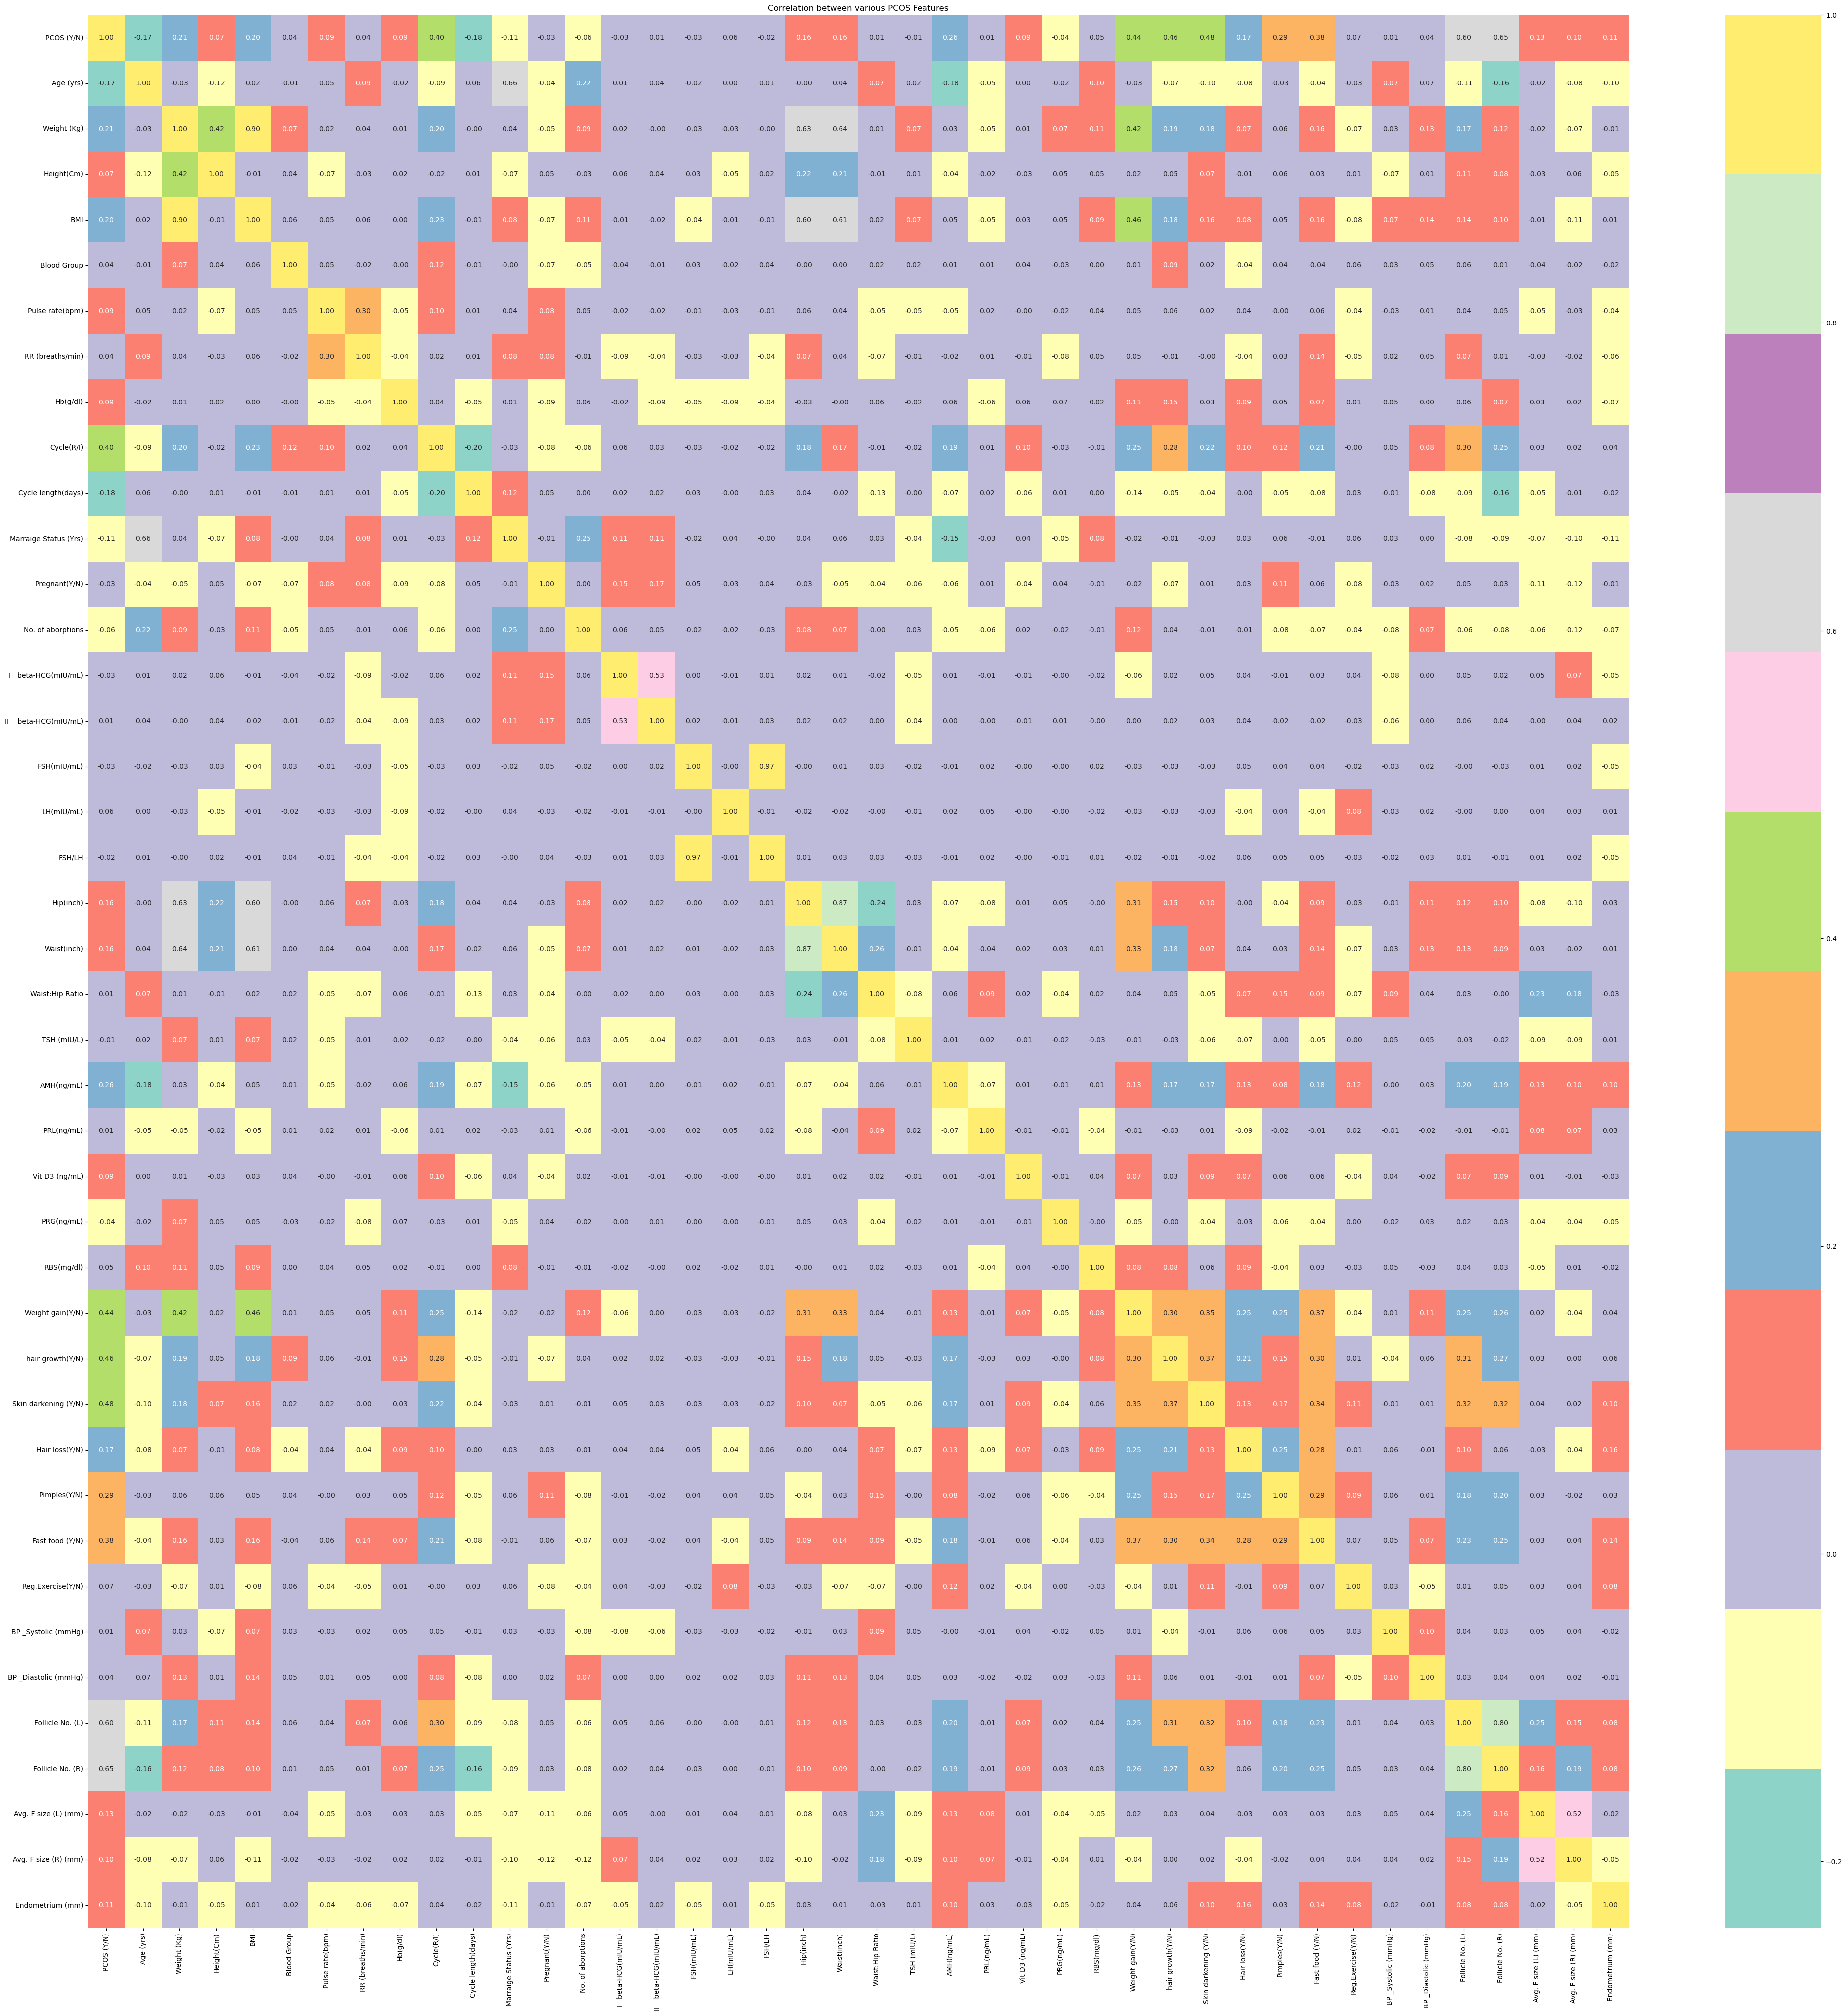

time: 4.17 s (started: 2023-04-09 14:39:02 +05:30)


In [45]:
# Heatmap for correlation between all the features
correlation=df.corr()
plt.subplots(figsize=(50,50))
sns.heatmap(correlation,cmap="Set3",annot=True,fmt=".2f")
plt.title("Correlation between various PCOS Features")
plt.show()

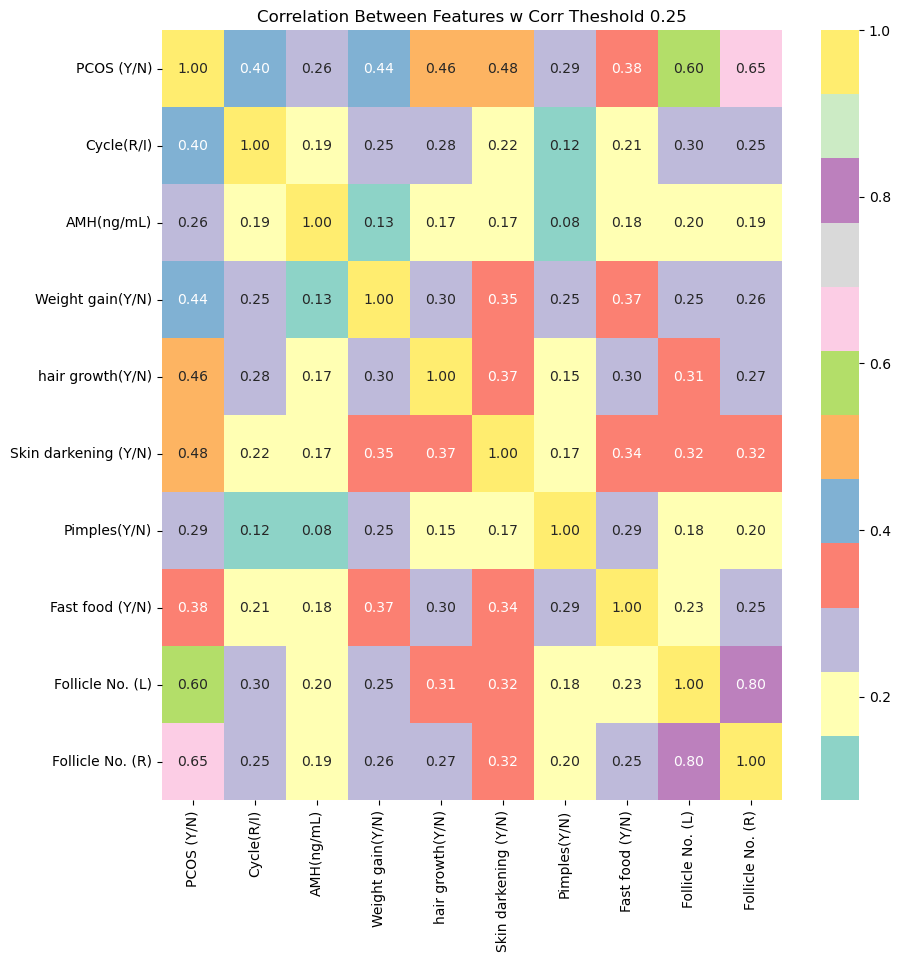

time: 422 ms (started: 2023-04-09 14:39:07 +05:30)


In [46]:
# Heatmap for correlation between the features having correlation > 0.25
threshold = 0.25
filtre = np.abs(correlation["PCOS (Y/N)"]) > threshold 
corr_features = correlation.columns[filtre]
plt.subplots(figsize=(10,10))
sns.heatmap(df[corr_features].corr(),cmap="Set3", annot = True, fmt = ".2f")
plt.title("Correlation Between Features w Corr Theshold 0.25")
plt.show()

In [47]:
corr_features

Index(['PCOS (Y/N)', 'Cycle(R/I)', 'AMH(ng/mL)', 'Weight gain(Y/N)',
       'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Follicle No. (L)', 'Follicle No. (R)'],
      dtype='object')

time: 0 ns (started: 2023-04-09 14:39:07 +05:30)


In [48]:
data=df[corr_features]
data

,PCOS (Y/N),Cycle(R/I),AMH(ng/mL),Weight gain(Y/N),hair growth(Y/N),Skin darkening (Y/N),Pimples(Y/N),Fast food (Y/N),Follicle No. (L),Follicle No. (R)
0,0,2,2.07,0,0,0,0,1.00,3,3
1,0,2,1.53,0,0,0,0,0.00,3,5
2,1,2,6.63,0,0,0,1,1.00,13,15
3,0,2,1.22,0,0,0,0,0.00,2,2
4,0,2,2.26,0,0,0,0,0.00,3,4
...,...,...,...,...,...,...,...,...,...,...
536,0,2,1.70,0,0,0,0,0.00,1,0
537,0,2,5.60,1,0,0,0,0.00,9,7
538,0,2,3.70,0,0,0,0,0.00,1,0
539,0,4,5.20,0,0,0,1,0.00,7,6


time: 15 ms (started: 2023-04-09 14:39:12 +05:30)


In [ ]:
X = data.drop(labels = ["PCOS (Y/N)"],axis = 1)
y = data['PCOS (Y/N)']

time: 2.17 ms (started: 2023-04-07 12:20:49 +00:00)


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

time: 3.35 ms (started: 2023-04-07 12:20:49 +00:00)


In [ ]:
# Scaling data to use wherever necessary

# normalizer = MinMaxScaler()
standardizer = StandardScaler()
X_standardized = standardizer.fit_transform(X)
X_train_standardized = standardizer.fit_transform(X_train)
X_test_standardized = standardizer.fit_transform(X_test)

time: 16.1 ms (started: 2023-04-07 12:20:49 +00:00)


In [ ]:
# Unscaled Data
lz_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = lz_clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████| 29/29 [00:01<00:00, 27.51it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
PassiveAggressiveClassifier        0.83               0.81     0.81      0.83   
NearestCentroid                    0.83               0.81     0.81      0.83   
SGDClassifier                      0.83               0.79     0.79      0.83   
GaussianNB                         0.83               0.79     0.79      0.83   
NuSVC                              0.83               0.79     0.79      0.83   
RidgeClassifier                    0.83               0.79     0.79      0.83   
SVC                                0.83               0.78     0.78      0.82   
LinearSVC                          0.82               0.78     0.78      0.82   
LinearDiscriminantAnalysis         0.82               0.78     0.78      0.82   
CalibratedClassifierCV             0.82               0.78     0.78      0.82   
LogisticRegression          

In [ ]:
# Scaled Data
lz_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = lz_clf.fit(X_train_standardized, X_test_standardized, y_train, y_test)
print(models)

100%|██████████| 29/29 [00:03<00:00,  9.49it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
PassiveAggressiveClassifier        0.85               0.83     0.83      0.85   
SGDClassifier                      0.84               0.82     0.82      0.84   
NearestCentroid                    0.83               0.81     0.81      0.83   
AdaBoostClassifier                 0.83               0.81     0.81      0.83   
GaussianNB                         0.83               0.81     0.81      0.83   
LGBMClassifier                     0.84               0.81     0.81      0.84   
KNeighborsClassifier               0.83               0.80     0.80      0.83   
ExtraTreesClassifier               0.83               0.80     0.80      0.83   
LinearSVC                          0.83               0.79     0.79      0.83   
LogisticRegression                 0.83               0.79     0.79      0.83   
CalibratedClassifierCV      

In [ ]:
# Logistic Regression
lr_clf = LogisticRegression()

#Building a dictionalry with list of optional values that will be analysed by GridSearchCV
parameters = { 
    'penalty' : ['l1','l2'], 
    'C' : np.logspace(-3,3,7),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    'max_iter' : [100, 500, 1500, 2000],
    'class_weight' : ['None', 'balanced']
}

#Fitting the training set to find parameters with best accuracy
best_lr_clf = GridSearchCV(estimator=lr_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_lr_clf.fit(X_train_standardized, y_train)



#Getting the outcome of gridsearchcv
best_lr_clf_params = best_lr_clf.best_params_
print(best_lr_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_lr_clf.best_estimator_.predict(X_test_standardized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_lr_clf.best_estimator_.score(X_train_standardized, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_lr_clf.best_estimator_.score(X_test_standardized, y_test)*100))

Fitting 3 folds for each of 560 candidates, totalling 1680 fits
{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy: 82.21%
Accuracy on Training Data: 84.92%
Accuracy on Testing Data: 82.21%
time: 2.45 s (started: 2023-04-07 07:03:02 +00:00)


In [ ]:
# AdaBoost Classifier
ada_clf = AdaBoostClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'n_estimators' : [10, 50, 100, 500],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

#Fitting the training set to find parameters with best accuracy
best_ada_clf = GridSearchCV(estimator=ada_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_ada_clf.fit(X_train, y_train)

#Getting the outcome of gridsearchcv
best_ada_clf_params = best_ada_clf.best_params_
print(best_ada_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_ada_clf.best_estimator_.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_ada_clf.best_estimator_.score(X_train, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_ada_clf.best_estimator_.score(X_test, y_test)*100))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
Accuracy: 77.30%
Accuracy on Training Data: 85.98%
Accuracy on Testing Data: 77.30%
time: 28.9 s (started: 2023-04-07 07:03:05 +00:00)


In [ ]:
# Random Forest
rf_clf = RandomForestClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'bootstrap': [True, False],
    'n_estimators': [200, 500, 800, 1000, 1500, 2000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10, 30, 50, 80, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'criterion' :['gini', 'entropy'],
    'n_jobs':[-1]
}

#Fitting the training set to find parameters with best accuracy
best_rf_clf = GridSearchCV(estimator=rf_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_rf_clf.fit(X_train, y_train)

#Getting the outcome of gridsearchcv
best_rf_clf_params = best_rf_clf.best_params_
print(best_rf_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_rf_clf.best_estimator_.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_rf_clf.best_estimator_.score(X_train, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_rf_clf.best_estimator_.score(X_test, y_test)*100))

In [ ]:
# ExtraTrees Classifier
et_clf = ExtraTreesClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = {
    'n_estimators': [100,200,500,1000,1500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2,8,16,32,50],
    'min_samples_split': [2,4,6],
    'min_samples_leaf': [1,2],
    #'oob_score': [True, False],
    'max_features': ['sqrt','log2','None'],    
    'bootstrap': [True, False],
    'warm_start': [True, False],
}

#Fitting the training set to find parameters with best accuracy
best_et_clf = GridSearchCV(estimator=et_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_et_clf.fit(X_train, y_train)

#Getting the outcome of gridsearchcv
best_et_clf_params = best_et_clf.best_params_
print(best_et_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_et_clf.best_estimator_.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_et_clf.best_estimator_.score(X_train, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_et_clf.best_estimator_.score(X_test, y_test)*100))

Fitting 3 folds for each of 5400 candidates, totalling 16200 fits


KeyboardInterrupt: ignored

time: 10min 16s (started: 2023-04-06 14:19:19 +00:00)


In [ ]:
# MLP Classifier
mlp_clf = MLPClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': 10.0 ** -np.arange(1, 7),
    'max_iter': [400, 800, 1500, 2000],
    'hidden_layer_sizes': [(25, 50), (25, 50, 100)], 
    'random_state': [0,1,2,5,9],
    'learning_rate': ["constant", "invscaling", "adaptive"]
}

#Fitting the training set to find parameters with best accuracy
best_mlp_clf = GridSearchCV(estimator=mlp_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_mlp_clf.fit(X_train_standardized, y_train)

#Getting the outcome of gridsearchcv
best_mlp_clf_params = best_mlp_clf.best_params_
print(best_mlp_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_mlp_clf.best_estimator_.predict(X_test_standardized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_mlp_clf.best_estimator_.score(X_train_standardized, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_mlp_clf.best_estimator_.score(X_test_standardized, y_test)*100))

In [ ]:
# Linear SVC
svm_clf = SVC()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'], 
    'degree' : [1,2,3,4,5,6], 
    'class_weight' : ['None', 'balanced']
}

#Fitting the training set to find parameters with best accuracy
best_svm_clf = GridSearchCV(estimator=svm_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_svm_clf.fit(X_train_standardized, y_train)

#Getting the outcome of gridsearchcv
best_svm_clf_params = best_svm_clf.best_params_
print(best_svm_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_svm_clf.best_estimator_.predict(X_test_standardized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_svm_clf.best_estimator_.score(X_train_standardized, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_svm_clf.best_estimator_.score(X_test_standardized, y_test)*100))

In [ ]:
# K Nearest Neighbors Classifier
knn_clf = KNeighborsClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'n_neighbors' : list(range(2,31,2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': list(range(20,41,3)),
    'p': [1, 2]
}

#Fitting the training set to find parameters with best accuracy
best_knn_clf = GridSearchCV(estimator=knn_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_knn_clf.fit(X_train_standardized, y_train)

#Getting the outcome of gridsearchcv
best_knn_clf_params = best_knn_clf.best_params_
print(best_knn_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_knn_clf.best_estimator_.predict(X_test_standardized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_knn_clf.best_estimator_.score(X_train_standardized, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_knn_clf.best_estimator_.score(X_test_standardized, y_test)*100))

In [ ]:
# Stochastic Gradient Descent Classifier
sgd_clf = SGDClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    "loss" : ["hinge", "log_loss", "squared_hinge", "modified_huber", "perceptron"],
    "penalty" : ["l2", "l1", "none", "elasticnet"],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1]
}

#Fitting the training set to find parameters with best accuracy
best_sgd_clf = GridSearchCV(estimator=sgd_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_sgd_clf.fit(X_train_standardized, y_train)

#Getting the outcome of gridsearchcv
best_sgd_clf_params = best_sgd_clf.best_params_
print(best_sgd_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_sgd_clf.best_estimator_.predict(X_test_standardized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_sgd_clf.best_estimator_.score(X_train_standardized, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_sgd_clf.best_estimator_.score(X_test_standardized, y_test)*100))

In [ ]:
# Create the classifiers
lr_clf = LogisticRegression(**{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}) # done
ada_clf = AdaBoostClassifier(**{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 500}) # done
#rf_clf = RandomForestClassifier(**best_rf_clf_params, random_state=42)
# rf_clf = RandomForestClassifier(**{'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 500, 'n_jobs': None})
rf_clf = RandomForestClassifier()
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
svm_clf = SVC(**{'C': 10, 'class_weight': 'balanced', 'degree': 1, 'gamma': 0.0001, 'kernel': 'rbf'}) # done
knn_clf = KNeighborsClassifier(**{'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}) # done
sgd_clf = SGDClassifier(**{'alpha': 0.01, 'l1_ratio': 0.8, 'loss': 'log_loss', 'penalty': 'elasticnet'}) # done

# Create the ensemble voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr_clf), ('ada', ada_clf), ('rf', rf_clf), ('et', et_clf), ('mlp', mlp_clf), ('svm', svm_clf), ('knn', knn_clf), ('sgd', sgd_clf)],
    voting='hard'
)

time: 5.13 ms (started: 2023-04-07 13:07:42 +00:00)


In [ ]:
# Train the individual classifiers
lr_clf.fit(X_train_standardized, y_train)
ada_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
et_clf.fit(X_train, y_train)
mlp_clf.fit(X_train_standardized, y_train)
svm_clf.fit(X_train_standardized, y_train)
knn_clf.fit(X_train_standardized, y_train)
sgd_clf.fit(X_train_standardized, y_train)

# Train the ensemble voting classifier
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 penalty='l1', solver='saga')),
                             ('ada',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=500)),
                             ('rf',
                              RandomForestClassifier(max_depth=9,
                                                     max_features='log2',
                                                     n_estimators=500)),
                             ('et', ExtraTreesClassifier(random_state=42)),
                             ('mlp',
                              MLPClassifier(max_iter=1000, random_state=42)),
                             ('svm',
                              SVC(C=10, class_weight='balanced', degree=1,
                                  gamma=0.0001)),
                             ('knn',
                              KNeighborsClassifier(algorithm='ball_tree',
                                                   leaf_size=20,
                                                   metric='manhattan',
                                                   n_neighbors=4, p=1,
                                                   weights='distance')),
                             ('sgd',
                              SGDClassifier(alpha=0.01, l1_ratio=0.8,
                                            loss='log_loss',
                                            penalty='elasticnet'))])

time: 10.4 s (started: 2023-04-07 12:25:02 +00:00)


In [ ]:
# Train the ensemble voting classifier
voting_clf.fit(X_train, y_train)

# Predict using the individual and ensemble classifiers
y_pred_lr = lr_clf.predict(X_test_standardized)
y_pred_ada = ada_clf.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_et = et_clf.predict(X_test)
y_pred_mlp = mlp_clf.predict(X_test_standardized)
y_pred_svm = svm_clf.predict(X_test_standardized)
y_pred_knn = knn_clf.predict(X_test_standardized)
y_pred_sgd = sgd_clf.predict(X_test_standardized)
y_pred_voting = voting_clf.predict(X_test)

# Calculate the accuracy of the classifiers
accuracy_lr = accuracy_score(y_test, y_pred_lr)*100
accuracy_ada = accuracy_score(y_test, y_pred_ada)*100
accuracy_rf = accuracy_score(y_test, y_pred_rf)*100
accuracy_et = accuracy_score(y_test, y_pred_et)*100
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)*100
accuracy_svm = accuracy_score(y_test, y_pred_svm)*100
accuracy_knn = accuracy_score(y_test, y_pred_knn)*100
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)*100
accuracy_voting = accuracy_score(y_test, y_pred_voting)*100

print('Logistic Regression accuracy: %.2f' % accuracy_lr)
print('AdaBoost accuracy: %.2f' % accuracy_ada)
print('Random Forest accuracy: %.2f' % accuracy_rf)
print('Extra Trees accuracy: %.2f' % accuracy_et)
print('MLP accuracy: %.2f' % accuracy_mlp)
print('SVM accuracy: %.2f' % accuracy_svm)
print('KNN accuracy: %.2f' % accuracy_knn)
print('SGD accuracy: %.2f' % accuracy_sgd)
print('Ensemble Voting accuracy: %.2f' % accuracy_voting)

Logistic Regression accuracy: 87.73
AdaBoost accuracy: 88.34
Random Forest accuracy: 89.57
Extra Trees accuracy: 89.57
MLP accuracy: 88.34
SVM accuracy: 88.34
KNN accuracy: 86.50
SGD accuracy: 90.80
Ensemble Voting accuracy: 90.80
time: 6.43 s (started: 2023-04-07 12:25:12 +00:00)


In [ ]:
print('-------------------Logistic Regression accuracy----------------------')
print('Train Data: %.2f' % (lr_clf.score(X_train_standardized, y_train)*100))
print('Test Data: %.2f' % (lr_clf.score(X_test_standardized, y_test)*100))

print('-------------------AdaBoost accuracy----------------------')
print('Train Data: %.2f' % (ada_clf.score(X_train, y_train)*100))
print('Test Data: %.2f' % (ada_clf.score(X_test, y_test)*100))

print('-------------------Random Forest accuracy----------------------')
print('Train Data: %.2f' % (rf_clf.score(X_train, y_train)*100))
print('Test Data: %.2f' % (rf_clf.score(X_test, y_test)*100))

print('-------------------Extra Trees accuracy----------------------')
print('Train Data: %.2f' % (et_clf.score(X_train, y_train)*100))
print('Test Data: %.2f' % (et_clf.score(X_test, y_test)*100))

print('-------------------MLP accuracy----------------------')
print('Train Data: %.2f' % (mlp_clf.score(X_train_standardized, y_train)*100))
print('Test Data: %.2f' % (mlp_clf.score(X_test_standardized, y_test)*100))

print('-------------------SVM accuracy----------------------')
print('Train Data: %.2f' % (svm_clf.score(X_train_standardized, y_train)*100))
print('Test Data: %.2f' % (svm_clf.score(X_test_standardized, y_test)*100))

print('-------------------KNN accuracy----------------------')
print('Train Data: %.2f' % (knn_clf.score(X_train_standardized, y_train)*100))
print('Test Data: %.2f' % (knn_clf.score(X_test_standardized, y_test)*100))

print('-------------------SGD accuracy----------------------')
print('Train Data: %.2f' % (sgd_clf.score(X_train_standardized, y_train)*100))
print('Test Data: %.2f' % (sgd_clf.score(X_test_standardized, y_test)*100))

print('-------------------Ensemble Voting accuracy----------------------')
print('Train Data: %.2f' % (voting_clf.score(X_train, y_train)*100))
print('Test Data: %.2f' % (voting_clf.score(X_test, y_test)*100))

-------------------Logistic Regression accuracy----------------------
Train Data: 92.33
Test Data: 87.73
-------------------AdaBoost accuracy----------------------
Train Data: 94.71
Test Data: 88.34
-------------------Random Forest accuracy----------------------
Train Data: 99.74
Test Data: 89.57
-------------------Extra Trees accuracy----------------------
Train Data: 100.00
Test Data: 89.57
-------------------MLP accuracy----------------------
Train Data: 99.21
Test Data: 88.34
-------------------SVM accuracy----------------------
Train Data: 90.74
Test Data: 88.34
-------------------KNN accuracy----------------------
Train Data: 100.00
Test Data: 86.50
-------------------SGD accuracy----------------------
Train Data: 92.86
Test Data: 90.80
-------------------Ensemble Voting accuracy----------------------
Train Data: 98.15
Test Data: 90.80
time: 1.02 s (started: 2023-04-07 12:25:19 +00:00)


-----Logistic Regression-----
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       110
           1       0.79      0.85      0.82        53

    accuracy                           0.88       163
   macro avg       0.86      0.87      0.86       163
weighted avg       0.88      0.88      0.88       163



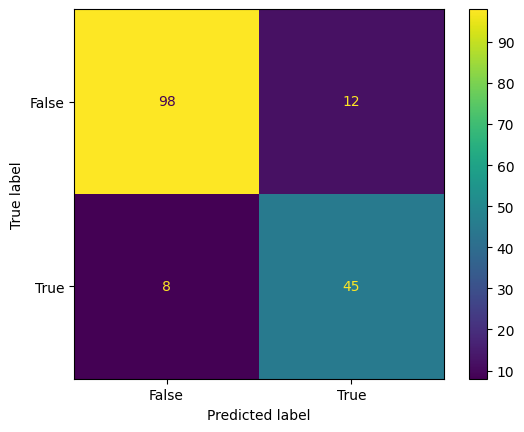

-----AdaBoost-----
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       110
           1       0.87      0.75      0.81        53

    accuracy                           0.88       163
   macro avg       0.88      0.85      0.86       163
weighted avg       0.88      0.88      0.88       163



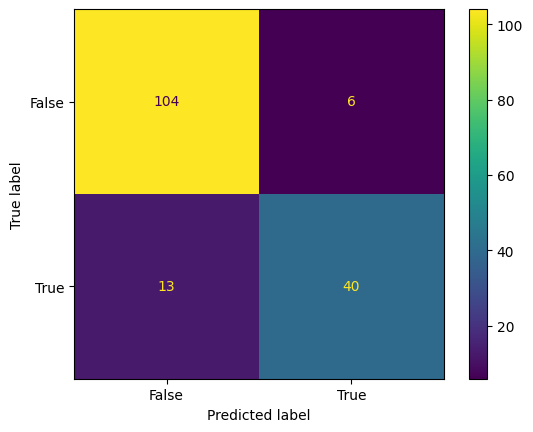

-----Random Forest-----
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       110
           1       0.85      0.83      0.84        53

    accuracy                           0.90       163
   macro avg       0.88      0.88      0.88       163
weighted avg       0.90      0.90      0.90       163



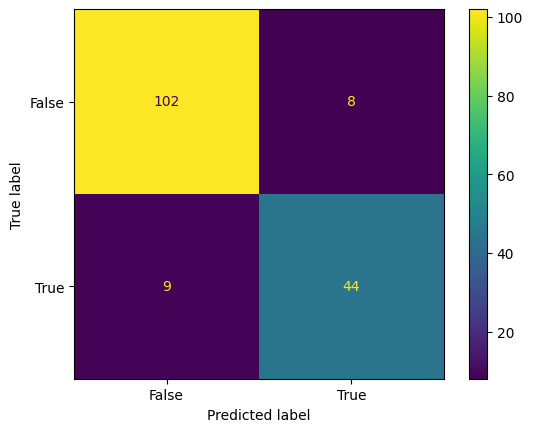

-----ExtraTree-----
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       110
           1       0.91      0.75      0.82        53

    accuracy                           0.90       163
   macro avg       0.90      0.86      0.88       163
weighted avg       0.90      0.90      0.89       163



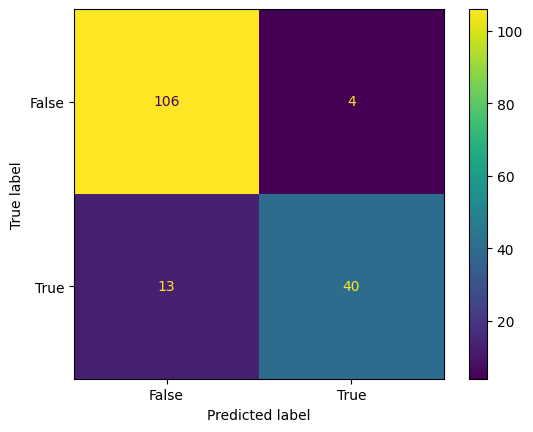

-----Multi-Layer Perceptron-----
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       110
           1       0.83      0.81      0.82        53

    accuracy                           0.88       163
   macro avg       0.87      0.86      0.87       163
weighted avg       0.88      0.88      0.88       163



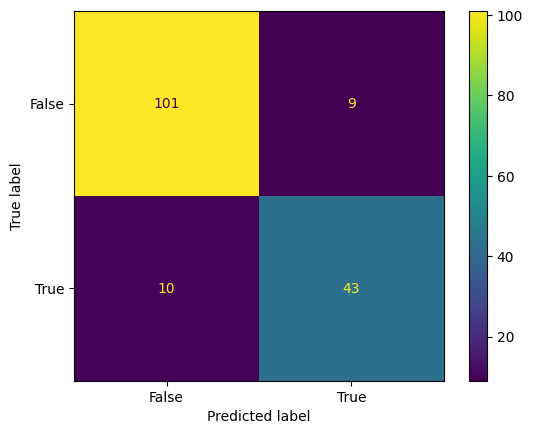

-----Support Vector Machine-----
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       110
           1       0.83      0.81      0.82        53

    accuracy                           0.88       163
   macro avg       0.87      0.86      0.87       163
weighted avg       0.88      0.88      0.88       163



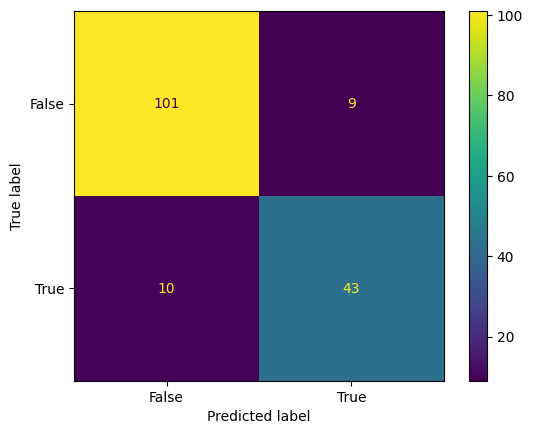

-----K-Nearest Neighbor-----
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       110
           1       0.84      0.72      0.78        53

    accuracy                           0.87       163
   macro avg       0.86      0.83      0.84       163
weighted avg       0.86      0.87      0.86       163



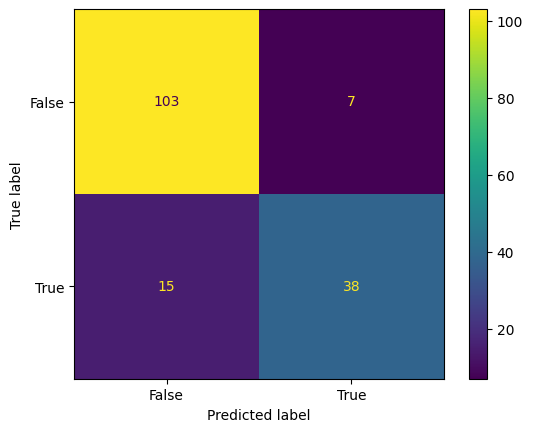

-----Stochastic Gradient Descent-----
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       110
           1       0.88      0.83      0.85        53

    accuracy                           0.91       163
   macro avg       0.90      0.89      0.89       163
weighted avg       0.91      0.91      0.91       163



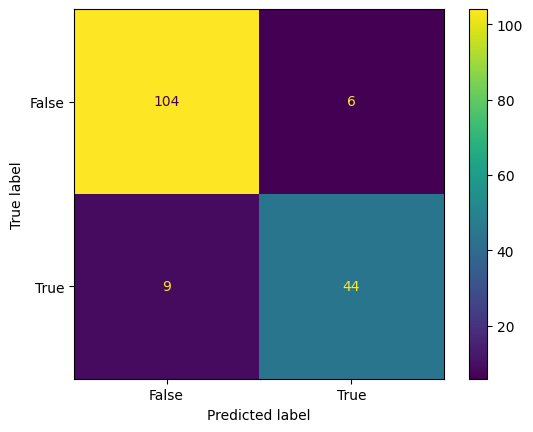

-----Ensemble Voting-----
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       110
           1       0.88      0.83      0.85        53

    accuracy                           0.91       163
   macro avg       0.90      0.89      0.89       163
weighted avg       0.91      0.91      0.91       163



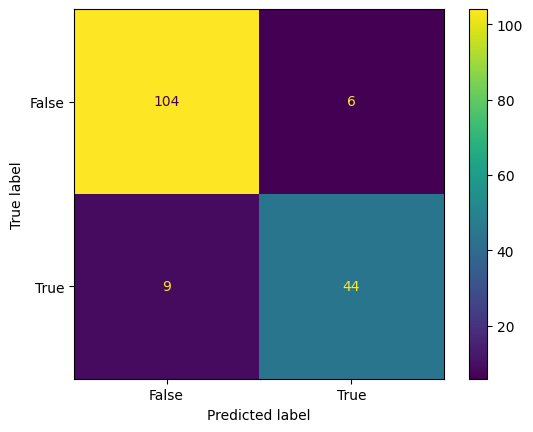

time: 2.23 s (started: 2023-04-07 12:25:20 +00:00)


In [ ]:
print('-----Logistic Regression-----')
classi_report_lr = classification_report(y_test, y_pred_lr)
print(classi_report_lr)
cm = confusion_matrix(y_test, y_pred_lr, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----AdaBoost-----')
classi_report_ada = classification_report(y_test, y_pred_ada)
print(classi_report_ada)
cm = confusion_matrix(y_test, y_pred_ada, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----Random Forest-----')
classi_report_rf = classification_report(y_test, y_pred_rf)
print(classi_report_rf)
cm = confusion_matrix(y_test, y_pred_rf, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----ExtraTree-----')
classi_report_et = classification_report(y_test, y_pred_et)
print(classi_report_et)
cm = confusion_matrix(y_test, y_pred_et, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----Multi-Layer Perceptron-----')
classi_report_mlp = classification_report(y_test, y_pred_mlp)
print(classi_report_mlp)
cm = confusion_matrix(y_test, y_pred_mlp, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----Support Vector Machine-----')
classi_report_svm = classification_report(y_test, y_pred_svm)
print(classi_report_svm)
cm = confusion_matrix(y_test, y_pred_svm, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----K-Nearest Neighbor-----')
classi_report_knn = classification_report(y_test, y_pred_knn)
print(classi_report_knn)
cm = confusion_matrix(y_test, y_pred_knn, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----Stochastic Gradient Descent-----')
classi_report_sgd = classification_report(y_test, y_pred_sgd)
print(classi_report_sgd)
cm = confusion_matrix(y_test, y_pred_sgd, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

print('-----Ensemble Voting-----')
classi_report_voting = classification_report(y_test, y_pred_voting)
print(classi_report_voting)
cm = confusion_matrix(y_test, y_pred_voting, labels = [False, True])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
cm_disp.plot()
plt.show()

### Applying PCA

In [ ]:
X = df.drop(labels = ["PCOS (Y/N)"],axis = 1)
y = df['PCOS (Y/N)']

time: 9.88 ms (started: 2023-04-06 17:59:49 +00:00)


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

time: 10.8 ms (started: 2023-04-06 17:59:52 +00:00)


In [ ]:
# normalizer = MinMaxScaler()
standardizer = StandardScaler()
X_standardized = standardizer.fit_transform(X)
X_train_standardized = standardizer.fit_transform(X_train)
X_test_standardized = standardizer.fit_transform(X_test)

time: 57.1 ms (started: 2023-04-06 17:59:54 +00:00)


In [ ]:
# PCA
pca = PCA(n_components=41)
pca.fit(X_train_standardized)
X_pca = pca.transform(X_test_standardized)

time: 27.3 ms (started: 2023-04-06 17:59:55 +00:00)


In [ ]:
# Get the column names of each principal component
component_names = ['PC'+str(i+1) for i in range(len(pca.components_))]
column_names = list(df.columns)

# Create a dictionary mapping component names to their corresponding column names
component_columns = {}
for i, name in enumerate(component_names):
    components = pca.components_[i]
    sorted_components = sorted(zip(components, column_names), reverse=True)
    component_columns[name] = [col for _, col in sorted_components]

# Print the component names and their corresponding column names
for name, columns in component_columns.items():
    print(f"{name}: {', '.join(columns)}")
    #print(len(columns))

PC1: Age (yrs), Height(Cm), RBS(mg/dl), Hip(inch), FSH/LH, Pimples(Y/N), BP _Diastolic (mmHg), Hb(g/dl), Follicle No. (L), hair growth(Y/N), Weight gain(Y/N), TSH (mIU/L), Weight (Kg), Hair loss(Y/N), BP _Systolic (mmHg), Skin darkening (Y/N), Pulse rate(bpm), Avg. F size (R) (mm), FSH(mIU/mL), Waist:Hip Ratio, BMI, Fast food (Y/N), Reg.Exercise(Y/N), Blood Group, RR (breaths/min), Waist(inch), PRG(ng/mL), Marraige Status (Yrs), AMH(ng/mL), Follicle No. (R), Pregnant(Y/N), I   beta-HCG(mIU/mL), Avg. F size (L) (mm), PRL(ng/mL), Vit D3 (ng/mL), II    beta-HCG(mIU/mL), No. of aborptions, Cycle length(days), LH(mIU/mL), PCOS (Y/N), Cycle(R/I)
PC2: PCOS (Y/N), Cycle length(days), Hip(inch), FSH/LH, Age (yrs), Height(Cm), Pregnant(Y/N), Cycle(R/I), Weight (Kg), Reg.Exercise(Y/N), BP _Systolic (mmHg), LH(mIU/mL), PRL(ng/mL), Waist:Hip Ratio, RBS(mg/dl), Vit D3 (ng/mL), Pulse rate(bpm), BMI, Marraige Status (Yrs), Blood Group, PRG(ng/mL), Waist(inch), I   beta-HCG(mIU/mL), RR (breaths/min), S

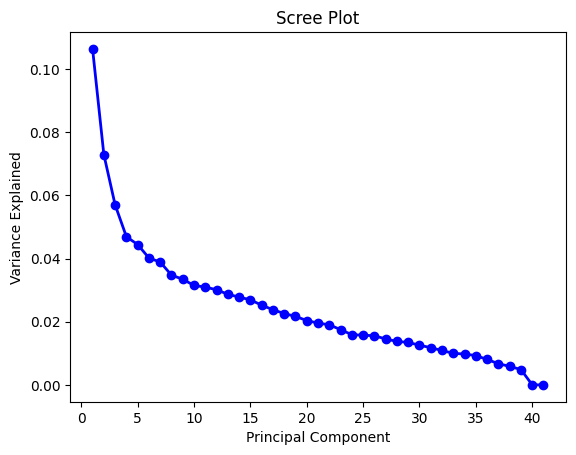

time: 405 ms (started: 2023-04-06 14:37:36 +00:00)


In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
# Apply PCA
pca = PCA(n_components=41)
X_train_pca = pca.fit_transform(X_train_standardized)
X_test_pca = pca.transform(X_test_standardized)

time: 7.53 ms (started: 2023-04-06 18:00:04 +00:00)


In [ ]:
lz_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = lz_clf.fit(X_train_pca, X_test_pca, y_train, y_test)
print(models)

100%|██████████| 29/29 [00:01<00:00, 16.63it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SGDClassifier                      0.88               0.88     0.88      0.88   
XGBClassifier                      0.90               0.87     0.87      0.90   
CalibratedClassifierCV             0.89               0.87     0.87      0.89   
AdaBoostClassifier                 0.88               0.87     0.87      0.88   
PassiveAggressiveClassifier        0.88               0.87     0.87      0.88   
Perceptron                         0.88               0.87     0.87      0.88   
LinearSVC                          0.87               0.86     0.86      0.87   
RidgeClassifierCV                  0.89               0.86     0.86      0.89   
RidgeClassifier                    0.89               0.86     0.86      0.89   
LogisticRegression                 0.88               0.86     0.86      0.88   
NearestCentroid             

Therefore, since there is not much improvement in the performance of any of the classifiers, applying PCA to this dataset is not much useful.

### Applying Hyper-parameter Tuning

In [ ]:
# Logistic Regression
lr_clf = LogisticRegression()

#Building a dictionalry with list of optional values that will be analysed by GridSearchCV
parameters = { 
    'penalty' : ['l1','l2'], 
    'C' : np.logspace(-3,3,7),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    'max_iter' : [100, 500, 1500, 2000],
    'class_weight' : ['None', 'balanced']
}

#Fitting the training set to find parameters with best accuracy
best_lr_clf = GridSearchCV(estimator=lr_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_lr_clf.fit(X_train_pca, y_train)



#Getting the outcome of gridsearchcv
best_lr_clf_params = best_lr_clf.best_params_
print(best_lr_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_lr_clf.best_estimator_.predict(X_test_pca)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_lr_clf.best_estimator_.score(X_train_pca, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_lr_clf.best_estimator_.score(X_test_pca, y_test)*100))

Fitting 3 folds for each of 560 candidates, totalling 1680 fits
{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy: 86.36%
Accuracy on Training Data: 90.91%
Accuracy on Testing Data: 86.36%
time: 21.8 s (started: 2023-04-06 14:39:09 +00:00)


In [ ]:
# AdaBoost Classifier
ada_clf = AdaBoostClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'n_estimators' : [10, 50, 100, 500],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

#Fitting the training set to find parameters with best accuracy
best_ada_clf = GridSearchCV(estimator=ada_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_ada_clf.fit(X_train_pca, y_train)

#Getting the outcome of gridsearchcv
best_ada_clf_params = best_ada_clf.best_params_
print(best_ada_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_ada_clf.best_estimator_.predict(X_test_pca)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_ada_clf.best_estimator_.score(X_train_pca, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_ada_clf.best_estimator_.score(X_test_pca, y_test)*100))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 100}
Accuracy: 87.12%
Accuracy on Training Data: 100.00%
Accuracy on Testing Data: 87.12%
time: 1min 12s (started: 2023-04-06 10:09:35 +00:00)


In [ ]:
# Random Forest
rf_clf = RandomForestClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'bootstrap': [True, False],
    'n_estimators': [200, 500, 800, 1000, 1500, 2000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10, 30, 50, 80, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'criterion' :['gini', 'entropy'],
    'n_jobs':[-1]
}

#Fitting the training set to find parameters with best accuracy
best_rf_clf = GridSearchCV(estimator=rf_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_rf_clf.fit(X_train_pca, y_train)

#Getting the outcome of gridsearchcv
best_rf_clf_params = best_rf_clf.best_params_
print(best_rf_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_rf_clf.best_estimator_.predict(X_test_pca)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_rf_clf.best_estimator_.score(X_train_pca, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_rf_clf.best_estimator_.score(X_test_pca, y_test)*100))

Fitting 3 folds for each of 3888 candidates, totalling 11664 fits


KeyboardInterrupt: ignored

time: 59min 47s (started: 2023-04-06 10:11:51 +00:00)


In [ ]:
# ExtraTrees Classifier
et_clf = ExtraTreesClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = {
    'n_estimators': [100,200,500,1000,1500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2,8,16,32,50],
    'min_samples_split': [2,4,6],
    'min_samples_leaf': [1,2],
    #'oob_score': [True, False],
    'max_features': ['sqrt','log2','None'],    
    'bootstrap': [True, False],
    'warm_start': [True, False],
}

#Fitting the training set to find parameters with best accuracy
best_et_clf = GridSearchCV(estimator=et_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_et_clf.fit(X_train_pca, y_train)

#Getting the outcome of gridsearchcv
best_et_clf_params = best_et_clf.best_params_
print(best_et_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_et_clf.best_estimator_.predict(X_test_pca)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_et_clf.best_estimator_.score(X_train_pca, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_et_clf.best_estimator_.score(X_test_pca, y_test)*100))

In [ ]:
# MLP Classifier
mlp_clf = MLPClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': 10.0 ** -np.arange(1, 7),
    'max_iter': [400, 800, 1500, 2000],
    'hidden_layer_sizes': [(25, 50), (25, 50, 100)], 
    'random_state': [0,1,2,5,9],
    'learning_rate': ["constant", "invscaling", "adaptive"]
}

#Fitting the training set to find parameters with best accuracy
best_mlp_clf = GridSearchCV(estimator=mlp_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_mlp_clf.fit(X_train_pca, y_train)

#Getting the outcome of gridsearchcv
best_mlp_clf_params = best_mlp_clf.best_params_
print(best_mlp_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_mlp_clf.best_estimator_.predict(X_test_pca)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_mlp_clf.best_estimator_.score(X_train_pca, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_mlp_clf.best_estimator_.score(X_test_pca, y_test)*100))

In [ ]:
# Linear SVC
svm_clf = SVC()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'], 
    'degree' : [1,2,3,4,5,6], 
    'class_weight' : ['None', 'balanced']
}

#Fitting the training set to find parameters with best accuracy
best_svm_clf = GridSearchCV(estimator=svm_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_svm_clf.fit(X_train_pca, y_train)

#Getting the outcome of gridsearchcv
best_svm_clf_params = best_svm_clf.best_params_
print(best_svm_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_svm_clf.best_estimator_.predict(X_test_pca)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_svm_clf.best_estimator_.score(X_train_pca, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_svm_clf.best_estimator_.score(X_test_pca, y_test)*100))

In [ ]:
# K Nearest Neighbors Classifier
knn_clf = KNeighborsClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    'n_neighbors' : list(range(2,31,2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': list(range(20,41,3)),
    'p': [1, 2]
}

#Fitting the training set to find parameters with best accuracy
best_knn_clf = GridSearchCV(estimator=knn_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_knn_clf.fit(X_train_pca, y_train)

#Getting the outcome of gridsearchcv
best_knn_clf_params = best_knn_clf.best_params_
print(best_knn_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_knn_clf.best_estimator_.predict(X_test_pca)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_knn_clf.best_estimator_.score(X_train_pca, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_knn_clf.best_estimator_.score(X_test_pca, y_test)*100))

In [ ]:
# Stochastic Gradient Descent Classifier
sgd_clf = SGDClassifier()

#Building a dictionalry with list of optional values that will me analysed by GridSearchCV
parameters = { 
    "loss" : ["hinge", "log_loss", "squared_hinge", "modified_huber", "perceptron"],
    "penalty" : ["l2", "l1", "none", "elasticnet"],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1]
}

#Fitting the training set to find parameters with best accuracy
best_sgd_clf = GridSearchCV(estimator=sgd_clf, param_grid=parameters, cv= 3, scoring = 'accuracy', verbose = 1, n_jobs = -1)
best_sgd_clf.fit(X_train_pca, y_train)

#Getting the outcome of gridsearchcv
best_sgd_clf_params = best_sgd_clf.best_params_
print(best_sgd_clf_params)

# Use the best estimator to make predictions on the test set
y_pred = best_sgd_clf.best_estimator_.predict(X_test_pca)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy on Training Data: {:.2f}%".format(best_sgd_clf.best_estimator_.score(X_train_pca, y_train)*100))
print("Accuracy on Testing Data: {:.2f}%".format(best_sgd_clf.best_estimator_.score(X_test_pca, y_test)*100))

In [ ]:
# Create the classifiers
lr_clf = LogisticRegression(**{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}) # done
ada_clf = AdaBoostClassifier(**{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 500}) # done
#rf_clf = RandomForestClassifier(**best_rf_clf_params, random_state=42)
# rf_clf = RandomForestClassifier(**{'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 500, 'n_jobs': None})
rf_clf = RandomForestClassifier()
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
svm_clf = SVC(**{'C': 10, 'class_weight': 'balanced', 'degree': 1, 'gamma': 0.0001, 'kernel': 'rbf'}) # done
knn_clf = KNeighborsClassifier(**{'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}) # done
sgd_clf = SGDClassifier(**{'alpha': 0.01, 'l1_ratio': 0.8, 'loss': 'log_loss', 'penalty': 'elasticnet'}) # done

# Create the ensemble voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr_clf), ('ada', ada_clf), ('rf', rf_clf), ('et', et_clf), ('mlp', mlp_clf), ('svm', svm_clf), ('knn', knn_clf), ('sgd', sgd_clf)],
    voting='hard'
)

time: 1.41 ms (started: 2023-04-06 18:01:06 +00:00)


In [ ]:
# Train the individual classifiers
lr_clf.fit(X_train_pca, y_train)
ada_clf.fit(X_train_pca, y_train)
rf_clf.fit(X_train_pca, y_train)
et_clf.fit(X_train_pca, y_train)
mlp_clf.fit(X_train_pca, y_train)
svm_clf.fit(X_train_pca, y_train)
knn_clf.fit(X_train_pca, y_train)
sgd_clf.fit(X_train_pca, y_train)

# Train the ensemble voting classifier
voting_clf.fit(X_train, y_train)

# Predict using the individual and ensemble classifiers
y_pred_lr = lr_clf.predict(X_test_pca)
y_pred_ada = ada_clf.predict(X_test_pca)
y_pred_rf = rf_clf.predict(X_test_pca)
y_pred_et = et_clf.predict(X_test_pca)
y_pred_mlp = mlp_clf.predict(X_test_pca)
y_pred_svm = svm_clf.predict(X_test_pca)
y_pred_knn = knn_clf.predict(X_test_pca)
y_pred_sgd = sgd_clf.predict(X_test_pca)
y_pred_voting = voting_clf.predict(X_test)

# Calculate the accuracy of the classifiers
accuracy_lr = accuracy_score(y_test, y_pred_lr)*100
accuracy_ada = accuracy_score(y_test, y_pred_ada)*100
accuracy_rf = accuracy_score(y_test, y_pred_rf)*100
accuracy_et = accuracy_score(y_test, y_pred_et)*100
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)*100
accuracy_svm = accuracy_score(y_test, y_pred_svm)*100
accuracy_knn = accuracy_score(y_test, y_pred_knn)*100
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)*100
accuracy_voting = accuracy_score(y_test, y_pred_voting)*100

print('Logistic Regression accuracy: %.2f' % accuracy_lr)
print('AdaBoost accuracy: %.2f' % accuracy_ada)
print('Random Forest accuracy: %.2f' % accuracy_rf)
print('Extra Trees accuracy: %.2f' % accuracy_et)
print('MLP accuracy: %.2f' % accuracy_mlp)
print('SVM accuracy: %.2f' % accuracy_svm)
print('KNN accuracy: %.2f' % accuracy_knn)
print('SGD accuracy: %.2f' % accuracy_sgd)
print('Ensemble Voting accuracy: %.2f' % accuracy_voting)

Logistic Regression accuracy: 87.12
AdaBoost accuracy: 89.39
Random Forest accuracy: 87.12
Extra Trees accuracy: 87.12
MLP accuracy: 84.09
SVM accuracy: 86.36
KNN accuracy: 81.82
SGD accuracy: 86.36
Ensemble Voting accuracy: 88.64
time: 10.7 s (started: 2023-04-06 18:05:08 +00:00)


# LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

time: 569 µs (started: 2023-04-06 14:29:55 +00:00)


In [ ]:
# Initialize the LDA classifier
lda = LinearDiscriminantAnalysis()

time: 701 µs (started: 2023-04-06 14:30:07 +00:00)


In [ ]:
# Perform 5-fold cross-validation
X = data.drop(labels = ["PCOS (Y/N)"],axis = 1)
y = data['PCOS (Y/N)']

time: 38.9 ms (started: 2023-04-06 14:30:56 +00:00)


In [ ]:
for i in [5,10]:
    cv_scores = cross_val_score(lda, X, y, cv=i)
    print("Applying %d fold cross validation:"%(i))
    # Print the accuracy scores for each fold
    print("Cross-validation scores:", cv_scores)

    # Calculate the average accuracy across all folds
    mean_accuracy = cv_scores.mean()
    print("Mean accuracy:", mean_accuracy)

Applying 5 fold cross validation:
Cross-validation scores: [0.94318182 0.89772727 0.82954545 0.95454545 0.84090909]
Mean accuracy: 0.8931818181818182
Applying 10 fold cross validation:
Cross-validation scores: [0.95454545 0.97727273 0.93181818 0.88636364 0.84090909 0.86363636
 0.93181818 1.         0.81818182 0.88636364]
Mean accuracy: 0.9090909090909092
time: 177 ms (started: 2023-04-06 14:36:45 +00:00)


# Forward Feature Selection

In [ ]:
X = df.drop(labels = ["PCOS (Y/N)"],axis = 1)
y = df['PCOS (Y/N)']

time: 1.87 ms (started: 2023-04-07 12:48:54 +00:00)


In [ ]:
models=[
    lr_clf,ada_clf,rf_clf,et_clf,mlp_clf,svm_clf,knn_clf,sgd_clf,voting_clf
]

time: 425 µs (started: 2023-04-07 12:48:55 +00:00)


In [ ]:
for i in models:
    # Sequential Forward Selection(sfs)
    sfs = SFS(i,k_features=10,forward=True,floating=False,scoring = 'r2',cv = 5)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Perform forward feature selection
    sfs.fit(X_train, y_train)

    # Transform the training and test data to contain only the selected features
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)

    # Train the model using only the selected features
    i.fit(X_train_selected, y_train)

    print(i)
    print('Training set score: ' + str(i.score(X_train_selected,y_train)))
    print('Test set score: ' + str(i.score(X_test_selected,y_test)))
    print()

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', solver='saga')
Training set score: 0.8912037037037037
Test set score: 0.8532110091743119




STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

AdaBoostClassifier(learning_rate=0.1, n_estimators=500)
Training set score: 0.8472222222222222
Test set score: 0.7981651376146789

RandomForestClassifier(max_depth=9, max_features='log2', n_estimators=500)
Training set score: 0.9837962962962963
Test set score: 0.8623853211009175

ExtraTreesClassifier(random_state=42)
Training set score: 1.0
Test set score: 0.8715596330275229

MLPClassifier(max_iter=1000, random_state=42)
Training set score: 0.9166666666666666
Test set score: 0.8807339449541285

SVC(C=10, class_weight='balanced', degree=1, gamma=0.0001)
Training set score: 0.8796296296296297
Test set score: 0.8165137614678899

KNeighborsClassifier(algorithm='ball_tree', leaf_size=20, metric='manhattan',
                     n_neighbors=4, p=1, weights='distance')
Training set score: 1.0
Test set score: 0.8256880733944955

SGDClassifier(alpha=0.01, l1_ratio=0.8, loss='log_loss', penalty='elasticnet')
Training set score: 0.9143518518518519
Test set score: 0.8899082568807339



# Backward Feature Selection

In [ ]:
X = df.drop(labels = ["PCOS (Y/N)"],axis = 1)
y = df['PCOS (Y/N)']

time: 2.2 ms (started: 2023-04-06 17:45:28 +00:00)


In [ ]:
models=[
    lr_clf,ada_clf,rf_clf,et_clf,mlp_clf,svm_clf,knn_clf,sgd_clf,voting_clf
]

time: 645 µs (started: 2023-04-06 17:45:29 +00:00)


In [ ]:
for i in models:
    # Sequential Backward Selection(sfs)
    sfs = SFS(i,k_features=10,forward=False,floating=False,scoring = 'r2',cv = 5)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Perform backward feature selection
    sfs.fit(X_train, y_train)

    # Transform the training and test data to contain only the selected features
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)

    # Train the model using only the selected features
    i.fit(X_train_selected, y_train)

    print(i)
    print('Training set score: ' + str(i.score(X_train_selected,y_train)))
    print('Test set score: ' + str(i.score(X_test_selected,y_test)))
    print()

InvalidIndexError: ignored

time: 190 ms (started: 2023-04-06 17:50:39 +00:00)


# Pipelining

In [ ]:
X = df.drop(labels = ["PCOS (Y/N)"],axis = 1)
y = df['PCOS (Y/N)']

time: 9.1 ms (started: 2023-04-07 13:07:23 +00:00)


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

time: 23.7 ms (started: 2023-04-07 13:07:24 +00:00)


### Pipelining using Variance Threshold

In [ ]:
models=[
    lr_clf,ada_clf,rf_clf,et_clf,mlp_clf,svm_clf,knn_clf,sgd_clf,voting_clf
]

time: 597 µs (started: 2023-04-07 13:07:56 +00:00)


In [ ]:
VarianceThreshold()

VarianceThreshold()

time: 4.13 ms (started: 2023-04-07 12:22:43 +00:00)


In [ ]:
for i in models:
    pipe = Pipeline([
('scaler', StandardScaler()),
('selector', VarianceThreshold(0.25)),
('classifier', i)
])
    pipe.fit(X_train, y_train)
    print(i)
    print('Training set score: ' + str(pipe.score(X_train,y_train)))
    print('Test set score: ' + str(pipe.score(X_test,y_test)))
    print()

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', solver='saga')
Training set score: 0.9232804232804233
Test set score: 0.8957055214723927

AdaBoostClassifier(learning_rate=0.1, n_estimators=500)
Training set score: 0.9470899470899471
Test set score: 0.8834355828220859

RandomForestClassifier()
Training set score: 1.0
Test set score: 0.8895705521472392

ExtraTreesClassifier(random_state=42)
Training set score: 1.0
Test set score: 0.8957055214723927

MLPClassifier(max_iter=1000, random_state=42)
Training set score: 0.9920634920634921
Test set score: 0.8773006134969326

SVC(C=10, class_weight='balanced', degree=1, gamma=0.0001)
Training set score: 0.9074074074074074
Test set score: 0.8895705521472392

KNeighborsClassifier(algorithm='ball_tree', leaf_size=20, metric='manhattan',
                     n_neighbors=4, p=1, weights='distance')
Training set score: 1.0
Test set score: 0.8895705521472392

SGDClassifier(alpha=0.01, l1_ratio=0.8, loss='log_loss', penalty='elasticnet'

### Pipelining using Select K Best features

In [ ]:
for i in models:
    pipe = Pipeline([
('scaler', StandardScaler()),
('selector', SelectKBest()),
('classifier', i)
])
    pipe.fit(X_train, y_train)
    print(i)
    print('Training set score: ' + str(pipe.score(X_train,y_train)))
    print('Test set score: ' + str(pipe.score(X_test,y_test)))
    print()

NameError: ignored

time: 32.7 ms (started: 2023-04-07 13:08:59 +00:00)


In [ ]:
for i in models:
    pipe = Pipeline([
('scaler', StandardScaler()),
('selector', SFS(i,k_features=10,forward=True,floating=False,scoring = 'r2',cv = 5)),
('classifier', i)
])
    pipe.fit(X_train, y_train)
    print(i)
    print('Training set score: ' + str(pipe.score(X_train,y_train)))
    print('Test set score: ' + str(pipe.score(X_test,y_test)))
    print()

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', solver='saga')
Training set score: 0.9074074074074074
Test set score: 0.8773006134969326




STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

ValueError: ignored

time: 2min 50s (started: 2023-04-07 12:45:53 +00:00)


## Confirming - DO NOT CHANGE ANYTHING HERE

In [31]:
lr_clf=LogisticRegression()
ada_clf=AdaBoostClassifier()
rf_clf=RandomForestClassifier()
et_clf=ExtraTreesClassifier()
mlp_clf=MLPClassifier()
svm_clf=SVC()
knn_clf=KNeighborsClassifier()
voting_clf=VotingClassifier(estimators=[('lr',lr_clf),('ada',ada_clf),('rf',rf_clf),('et',et_clf),('mlp',mlp_clf),('svm',svm_clf),('knn',knn_clf)],voting='hard')

time: 0 ns (started: 2023-04-09 23:53:51 +05:30)


In [32]:
models=[lr_clf,ada_clf,rf_clf,et_clf,mlp_clf,svm_clf,knn_clf,voting_clf]

time: 0 ns (started: 2023-04-09 23:53:52 +05:30)


In [33]:
kfold=KFold(n_splits=5,shuffle=True,random_state=42)

time: 0 ns (started: 2023-04-09 23:53:53 +05:30)


In [34]:
model_names=['Logistic Regression','AdaBoost Classifier','Random Forest Classifier','ExtraTree Classifier','Multi-Layer Perceptron','SVM Classifier','KNN Classifier','Ensemble Classifier']

time: 0 ns (started: 2023-04-09 23:53:54 +05:30)


### Before feature selection

In [ ]:
X=df.drop(['PCOS (Y/N)'],axis=1)
y=df['PCOS (Y/N)']

time: 9.35 ms (started: 2023-04-09 06:49:03 +00:00)


In [ ]:
j=0

time: 646 µs (started: 2023-04-09 06:49:06 +00:00)


In [ ]:
for model in models:
  scores=cross_val_score(model,X,y,cv=kfold)
  y_pred=cross_val_predict(model,X,y,cv=kfold)
  accuracy=accuracy_score(y,y_pred)
  score=np.mean(scores)
  confusion_mat=confusion_matrix(y,y_pred)
  print(model_names[j])
  j=j+1
  print("Score: ",score)  
  print("Overall accuracy: ",accuracy)
  print("Confusion matrix: \n",confusion_mat)
  print()

Logistic Regression
Score:  0.8559463132857628
Overall accuracy:  0.8558225508317929
Confusion matrix: 
 [[331  33]
 [ 45 132]]

AdaBoost Classifier
Score:  0.8743289160720353
Overall accuracy:  0.8743068391866913
Confusion matrix: 
 [[334  30]
 [ 38 139]]

Random Forest Classifier
Score:  0.8965851172273192
Overall accuracy:  0.8927911275415896
Confusion matrix: 
 [[347  17]
 [ 41 136]]

ExtraTree Classifier
Score:  0.8854060482500848
Overall accuracy:  0.8946395563770795
Confusion matrix: 
 [[348  16]
 [ 41 136]]

Multi-Layer Perceptron
Score:  0.7672952769283043
Overall accuracy:  0.7744916820702403
Confusion matrix: 
 [[313  51]
 [ 71 106]]

SVM Classifier
Score:  0.6764525993883793
Overall accuracy:  0.6765249537892791
Confusion matrix: 
 [[364   0]
 [175   2]]

KNN Classifier
Score:  0.6654434250764526
Overall accuracy:  0.6654343807763401
Confusion matrix: 
 [[307  57]
 [124  53]]

Ensemble Classifier
Score:  0.8743628950050969
Overall accuracy:  0.88909426987061
Confusion matri

### After feature selection using correlation

In [49]:
data=df[corr_features]
data

,PCOS (Y/N),Cycle(R/I),AMH(ng/mL),Weight gain(Y/N),hair growth(Y/N),Skin darkening (Y/N),Pimples(Y/N),Fast food (Y/N),Follicle No. (L),Follicle No. (R)
0,0,2,2.07,0,0,0,0,1.00,3,3
1,0,2,1.53,0,0,0,0,0.00,3,5
2,1,2,6.63,0,0,0,1,1.00,13,15
3,0,2,1.22,0,0,0,0,0.00,2,2
4,0,2,2.26,0,0,0,0,0.00,3,4
...,...,...,...,...,...,...,...,...,...,...
536,0,2,1.70,0,0,0,0,0.00,1,0
537,0,2,5.60,1,0,0,0,0.00,9,7
538,0,2,3.70,0,0,0,0,0.00,1,0
539,0,4,5.20,0,0,0,1,0.00,7,6


time: 0 ns (started: 2023-04-09 14:39:28 +05:30)


In [50]:
X = data.drop(labels = ["PCOS (Y/N)"],axis = 1)
y = data['PCOS (Y/N)']

time: 16 ms (started: 2023-04-09 14:39:29 +05:30)


In [51]:
j=0

time: 0 ns (started: 2023-04-09 14:39:30 +05:30)


In [52]:
X_standardized=StandardScaler().fit_transform(X)

time: 15 ms (started: 2023-04-09 14:39:32 +05:30)


In [53]:
for model in models:
    scores=cross_val_score(model,X_standardized,y,cv=kfold)
    y_pred=cross_val_predict(model,X_standardized,y,cv=kfold)
    accuracy=accuracy_score(y,y_pred)
    score=np.mean(scores)
    confusion_mat=confusion_matrix(y,y_pred)
    print(model_names[j])
    j=j+1
    print("Score: ",score)  
    print("Overall accuracy: ",accuracy)
    print("Confusion matrix: \n",confusion_mat)
    print()

Logistic Regression
Score:  0.9057424396873938
Overall accuracy:  0.9057301293900185
Confusion matrix: 
 [[340  24]
 [ 27 150]]

AdaBoost Classifier
Score:  0.8890927624872578
Overall accuracy:  0.88909426987061
Confusion matrix: 
 [[336  28]
 [ 32 145]]

Random Forest Classifier
Score:  0.8891437308868501
Overall accuracy:  0.8964879852125693
Confusion matrix: 
 [[341  23]
 [ 33 144]]

ExtraTree Classifier
Score:  0.8724940536867143
Overall accuracy:  0.8706099815157117
Confusion matrix: 
 [[334  30]
 [ 40 137]]

Multi-Layer Perceptron
Score:  0.8927964661909616
Overall accuracy:  0.8964879852125693
Confusion matrix: 
 [[337  27]
 [ 29 148]]

SVM Classifier
Score:  0.9002208630648998
Overall accuracy:  0.9001848428835489
Confusion matrix: 
 [[343  21]
 [ 33 144]]

KNN Classifier
Score:  0.8780496092422698
Overall accuracy:  0.878003696857671
Confusion matrix: 
 [[341  23]
 [ 43 134]]

Ensemble Classifier
Score:  0.8909616038056406
Overall accuracy:  0.88909426987061
Confusion matrix: 

### Applying forward feature selection

In [63]:
X = df.drop(labels = ["PCOS (Y/N)"],axis = 1)
y = df['PCOS (Y/N)']

time: 0 ns (started: 2023-04-09 15:13:38 +05:30)


In [64]:
j=0

time: 0 ns (started: 2023-04-09 15:13:38 +05:30)


In [65]:
for model in models:
    sfs = SFS(model, k_features=10, forward=True,floating=False)
    pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('sfs', sfs),
        ('classifier', model)
        ])
    scores=cross_val_score(pipeline,X,y,cv=kfold)
    y_pred=cross_val_predict(pipeline,X,y,cv=kfold)
    accuracy=accuracy_score(y,y_pred)
    score=np.mean(scores)
    confusion_mat=confusion_matrix(y,y_pred)
    print(model_names[j])
    j=j+1
    print("Score: ",score)  
    print("Overall accuracy: ",accuracy)
    print("Confusion matrix: \n",confusion_mat)
    print()


Logistic Regression
Score:  0.8853380903839619
Overall accuracy:  0.8853974121996303
Confusion matrix: 
 [[339  25]
 [ 37 140]]

AdaBoost Classifier
Score:  0.8502208630648997
Overall accuracy:  0.8502772643253235
Confusion matrix: 
 [[323  41]
 [ 40 137]]

Random Forest Classifier
Score:  0.8724770642201836
Overall accuracy:  0.8706099815157117
Confusion matrix: 
 [[340  24]
 [ 46 131]]

ExtraTree Classifier
Score:  0.8669215086646279
Overall accuracy:  0.8650646950092421
Confusion matrix: 
 [[334  30]
 [ 43 134]]

Multi-Layer Perceptron
Score:  0.8651036357458377
Overall accuracy:  0.878003696857671
Confusion matrix: 
 [[337  27]
 [ 39 138]]

SVM Classifier
Score:  0.8873258579680599
Overall accuracy:  0.8872458410351202
Confusion matrix: 
 [[345  19]
 [ 42 135]]

KNN Classifier
Score:  0.8705912334352701
Overall accuracy:  0.8706099815157117
Confusion matrix: 
 [[338  26]
 [ 44 133]]

Ensemble Classifier
Score:  0.8761467889908257
Overall accuracy:  0.8706099815157117
Confusion matr

### Applying Variance Threshold Feature Selection

In [37]:
X=df.drop(['PCOS (Y/N)'],axis=1)
y=df['PCOS (Y/N)']

time: 0 ns (started: 2023-04-09 14:33:25 +05:30)


In [38]:
j=0

time: 0 ns (started: 2023-04-09 14:33:25 +05:30)


In [40]:
for model in models:
    pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('selector', VarianceThreshold(0.25)),
    ('classifier', model)
    ])
    scores=cross_val_score(pipeline,X,y,cv=kfold)
    y_pred=cross_val_predict(pipeline,X,y,cv=kfold)
    accuracy=accuracy_score(y,y_pred)
    score=np.mean(scores)
    confusion_mat=confusion_matrix(y,y_pred)
    print(model_names[j])
    j=j+1
    print("Score: ",score)  
    print("Overall accuracy: ",accuracy)
    print("Confusion matrix: \n",confusion_mat)
    print()

Logistic Regression
Score:  0.8928644240570847
Overall accuracy:  0.8927911275415896
Confusion matrix: 
 [[342  22]
 [ 36 141]]

AdaBoost Classifier
Score:  0.8743289160720353
Overall accuracy:  0.8743068391866913
Confusion matrix: 
 [[334  30]
 [ 38 139]]

Random Forest Classifier
Score:  0.8984199796126402
Overall accuracy:  0.8872458410351202
Confusion matrix: 
 [[345  19]
 [ 42 135]]

ExtraTree Classifier
Score:  0.8928304451240232
Overall accuracy:  0.878003696857671
Confusion matrix: 
 [[343  21]
 [ 45 132]]

Multi-Layer Perceptron
Score:  0.8614339109751953
Overall accuracy:  0.8558225508317929
Confusion matrix: 
 [[328  36]
 [ 42 135]]

SVM Classifier
Score:  0.8835541963982332
Overall accuracy:  0.8835489833641405
Confusion matrix: 
 [[347  17]
 [ 46 131]]

KNN Classifier
Score:  0.8651206252123682
Overall accuracy:  0.8650646950092421
Confusion matrix: 
 [[346  18]
 [ 55 122]]

Ensemble Classifier
Score:  0.8965511382942575
Overall accuracy:  0.8983364140480592
Confusion matr

### Applying Select K Best Features 

In [41]:
X=df.drop(['PCOS (Y/N)'],axis=1)
y=df['PCOS (Y/N)']

time: 0 ns (started: 2023-04-09 14:34:33 +05:30)


In [42]:
j=0

time: 0 ns (started: 2023-04-09 14:34:34 +05:30)


In [43]:
for i in models:
    pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('selector', SelectKBest(k=10)),
    ('classifier', i)
    ])
    scores=cross_val_score(pipeline,X,y,cv=kfold)
    y_pred=cross_val_predict(pipeline,X,y,cv=kfold)
    accuracy=accuracy_score(y,y_pred)
    score=np.mean(scores)
    confusion_mat=confusion_matrix(y,y_pred)
    print(model_names[j])
    j=j+1
    print("Score: ",score)  
    print("Overall accuracy: ",accuracy)
    print("Confusion matrix: \n",confusion_mat)
    print()

Logistic Regression
Score:  0.8946992864424057
Overall accuracy:  0.8983364140480592
Confusion matrix: 
 [[349  15]
 [ 40 137]]

AdaBoost Classifier
Score:  0.8965341488277268
Overall accuracy:  0.8909426987060998
Confusion matrix: 
 [[347  17]
 [ 42 135]]

Random Forest Classifier
Score:  0.8965511382942575
Overall accuracy:  0.8983364140480592
Confusion matrix: 
 [[349  15]
 [ 40 137]]

ExtraTree Classifier
Score:  0.8965171593611961
Overall accuracy:  0.8927911275415896
Confusion matrix: 
 [[348  16]
 [ 42 135]]

Multi-Layer Perceptron
Score:  0.8946992864424057
Overall accuracy:  0.8983364140480592
Confusion matrix: 
 [[349  15]
 [ 40 137]]

SVM Classifier
Score:  0.8946822969758751
Overall accuracy:  0.8964879852125693
Confusion matrix: 
 [[348  16]
 [ 40 137]]

KNN Classifier
Score:  0.8946822969758751
Overall accuracy:  0.8927911275415896
Confusion matrix: 
 [[348  16]
 [ 42 135]]

Ensemble Classifier
Score:  0.8965511382942577
Overall accuracy:  0.8983364140480592
Confusion mat

### Applying PCA 

In [35]:
X=df.drop(['PCOS (Y/N)'],axis=1)
y=df['PCOS (Y/N)']

time: 0 ns (started: 2023-04-09 23:54:01 +05:30)


In [36]:
j=0

time: 0 ns (started: 2023-04-09 23:54:05 +05:30)


In [37]:
# Apply PCA
pca = PCA(n_components=41)

time: 0 ns (started: 2023-04-09 23:54:05 +05:30)


In [39]:
for i in models:
    pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('pca', pca),
    ('classifier', i)
    ])
    scores=cross_val_score(pipeline,X,y,cv=kfold)
    y_pred=cross_val_predict(pipeline,X,y,cv=kfold)
    accuracy=accuracy_score(y,y_pred)
    score=np.mean(scores)
    confusion_mat=confusion_matrix(y,y_pred)
    print(model_names[j])
    j=j+1
    print("Score: ",score)  
    print("Overall accuracy: ",accuracy)
    print("Confusion matrix: \n",confusion_mat)
    print()

Logistic Regression
Score:  0.8928644240570847
Overall accuracy:  0.8927911275415896
Confusion matrix: 
 [[342  22]
 [ 36 141]]

AdaBoost Classifier
Score:  0.8521746517159363
Overall accuracy:  0.8521256931608133
Confusion matrix: 
 [[327  37]
 [ 43 134]]

Random Forest Classifier
Score:  0.8613659531090724
Overall accuracy:  0.8632162661737524
Confusion matrix: 
 [[345  19]
 [ 55 122]]

ExtraTree Classifier
Score:  0.870676180767924
Overall accuracy:  0.866913123844732
Confusion matrix: 
 [[356   8]
 [ 64 113]]

Multi-Layer Perceptron
Score:  0.8725450220863064
Overall accuracy:  0.866913123844732
Confusion matrix: 
 [[337  27]
 [ 45 132]]

SVM Classifier
Score:  0.8835541963982332
Overall accuracy:  0.8835489833641405
Confusion matrix: 
 [[347  17]
 [ 46 131]]

KNN Classifier
Score:  0.8651206252123682
Overall accuracy:  0.8650646950092421
Confusion matrix: 
 [[346  18]
 [ 55 122]]

Ensemble Classifier
Score:  0.8872918790349983
Overall accuracy:  0.8853974121996303
Confusion matrix